In [1]:
import pandas as pd
import random
import numpy as np
import sklearn as sk
from scipy import stats
import statistics
import cvxpy as cvx
import xgboost
from sklearn.metrics import roc_curve, auc, confusion_matrix, roc_auc_score
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
xgboost.__version__
from scipy.linalg import svd
from scipy.spatial import ConvexHull
from sklearn.decomposition import PCA, NMF
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import math
from multiprocessing import Pool
from concurrent.futures import ProcessPoolExecutor, wait
from tqdm.notebook import tqdm
from deap import base, creator, tools, algorithms

import warnings
warnings.filterwarnings('ignore')

In [2]:
file_name = './compas-scores-two-years.csv'
full_data = pd.read_csv(file_name)
full_data.race.value_counts()

print(full_data.shape)

# remove groups with few instances 
full_data = full_data.query("race != 'Asian'").query("race != 'Native American'")

# group by felony or misdemenor charge
full_data.groupby(['c_charge_degree','is_recid'])['id'].count().reset_index()

# turn charge degree to numbers 
full_data['c_charge_degree'] = pd.Categorical(full_data['c_charge_degree'])
# change numbers into dummies (1 for present 0 for absent)
dummies = pd.get_dummies(full_data['c_charge_degree'], prefix='charge')
full_data = pd.concat([full_data, dummies], axis=1)

# remove bad data
full_data = full_data.query("days_b_screening_arrest <= 30") \
        .query("days_b_screening_arrest >= -30")\
        .query("is_recid != -1")\
        .query("c_charge_degree != 'O'") \
        .query("score_text != 'N/A'" )\
        .query("race != 'Asian'")\
        .query("race != 'Native American'")\
        .query("race != 'Other'")\
        .query("race != 'Hispanic'")

print(full_data.shape)

# randomize race for later use
full_data['race_random'] = np.random.permutation(full_data['race'])

# check how many random to the same thing
np.sum(full_data['race']==full_data['race_random'])

# check counts of recidivism by race
full_data.groupby(['race','is_recid'])['id'].count().reset_index()

# keep relevant columns 
columns_kept = ['sex', 'age', 'age_cat', 'race', 'juv_fel_count', 'priors_count', 'c_charge_degree', \
                'is_recid', 'decile_score', 'two_year_recid', 'c_jail_in', 'c_jail_out', 'race_random', \
                'charge_F', 'charge_M', 'score_text', 'id']
full_data = full_data.loc[:, columns_kept]

full_data = full_data.set_index('id')

full_data.head()

(7214, 53)
(5278, 55)


,sex,age,age_cat,race,juv_fel_count,priors_count,c_charge_degree,is_recid,decile_score,two_year_recid,c_jail_in,c_jail_out,race_random,charge_F,charge_M,score_text
id,,,,,,,,,,,,,,,,
3,Male,34,25 - 45,African-American,0,0,F,1,3,1,2013-01-26 03:45:27,2013-02-05 05:36:53,African-American,1,0,Low
4,Male,24,Less than 25,African-American,0,4,F,1,4,1,2013-04-13 04:58:34,2013-04-14 07:02:04,Caucasian,1,0,Low
8,Male,41,25 - 45,Caucasian,0,14,F,1,6,1,2014-02-18 05:08:24,2014-02-24 12:18:30,Caucasian,1,0,Medium
10,Female,39,25 - 45,Caucasian,0,0,M,0,1,0,2014-03-15 05:35:34,2014-03-18 04:28:46,African-American,0,1,Low
14,Male,27,25 - 45,Caucasian,0,0,F,0,4,0,2013-11-25 06:31:06,2013-11-26 08:26:57,Caucasian,1,0,Low


In [3]:
learning_data = full_data.copy(deep=True)
features_to_transform = ['age_cat', 'sex', 'race', 'c_charge_degree']

for feature in features_to_transform:
    dummies = pd.get_dummies(learning_data[feature], prefix=feature)
    learning_data = pd.concat([learning_data, dummies], axis = 1)
learning_data.head()

learning_data.columns = learning_data.columns.str.replace('-', '_')

learning_data['score_factor'] = np.where(learning_data['score_text'] == 'Low', 'Low', 'MediumHigh')
dummies = pd.get_dummies(learning_data['score_factor'])
learning_data = pd.concat([learning_data, dummies] , axis = 1)
learning_data.head()

,sex,age,age_cat,race,juv_fel_count,priors_count,c_charge_degree,is_recid,decile_score,two_year_recid,...,age_cat_Less than 25,sex_Female,sex_Male,race_African_American,race_Caucasian,c_charge_degree_F,c_charge_degree_M,score_factor,Low,MediumHigh
id,,,,,,,,,,,,,,,,,,,,,
3,Male,34,25 - 45,African-American,0,0,F,1,3,1,...,0,0,1,1,0,1,0,Low,1,0
4,Male,24,Less than 25,African-American,0,4,F,1,4,1,...,1,0,1,1,0,1,0,Low,1,0
8,Male,41,25 - 45,Caucasian,0,14,F,1,6,1,...,0,0,1,0,1,1,0,MediumHigh,0,1
10,Female,39,25 - 45,Caucasian,0,0,M,0,1,0,...,0,1,0,0,1,0,1,Low,1,0
14,Male,27,25 - 45,Caucasian,0,0,F,0,4,0,...,0,0,1,0,1,1,0,Low,1,0


In [4]:
X_Labels = ['sex_Male', 'age', 'race_African_American', 'priors_count',\
            'juv_fel_count', 'c_charge_degree_F', 'c_charge_degree_M']
Y_Labels = ['Low']


X =  learning_data.loc[:, X_Labels]
Y =  learning_data.loc[:, Y_Labels]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size =  0.2, random_state =  4)

# find and later remove linearly correlated pairs (not for xgboost but for LOCO later)
corr_thresh = .7
for column_a in X.columns:
    for column_b in X.columns:
        if column_a is not column_b:
            if X[column_a].corr(X[column_b]) > corr_thresh:
                print(column_a + " " + column_b)
    

xgb_full = xgboost.DMatrix(X, label=Y)
xgb_train =  xgboost.DMatrix(X_train, label = Y_train)
xgb_test = xgboost.DMatrix(X_test, label = Y_test)
# use validation set to choose # of trees
params = {
    "eta": 0.002,
    "max_depth": 4,
    "objective": 'binary:logistic',
    "eval_metric":"auc",
    #"tree_method": 'gpu_hist',
    "subsample": 0.5
}
#model_train = xgboost.train(params, xgb_train, 10000, evals = [(xgb_test, "test")], verbose_eval=1000)
model = xgboost.train(params, xgb_train, 10000, evals = [(xgb_test, "test")], verbose_eval= 1000)
xgboost.cv(params,xgb_full, nfold = 3, metrics="auc" , num_boost_round=10)
learning_data['pred'] = model.predict(xgb_full)


[0]	test-auc:0.79766
[1000]	test-auc:0.83840
[2000]	test-auc:0.83959
[3000]	test-auc:0.83853
[4000]	test-auc:0.83652
[5000]	test-auc:0.83459
[6000]	test-auc:0.83343
[7000]	test-auc:0.83205
[8000]	test-auc:0.83071
[9000]	test-auc:0.82942
[9999]	test-auc:0.82832


In [5]:
plt.hist(learning_data['pred'], bins = 20)
plt.show()

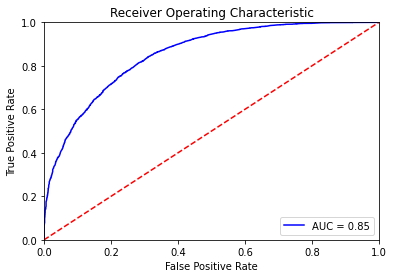

Optimal Threshold obtained using difference of TPR and FPR 0.52009827


In [6]:
%matplotlib inline
fpr, tpr , thresholds = roc_curve(learning_data['Low'], learning_data['pred'])
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

optimal_threshold = thresholds[np.argmax(tpr - fpr)]
print("Optimal Threshold obtained using difference of TPR and FPR " + str(optimal_threshold))
learning_data['y_pred'] = np.where(learning_data['pred'] > optimal_threshold, 1, 0)

## Find Burden

In [44]:
def d(indiv, other, cat, con, madArray, pred_func, columns=X_Labels):    
    dfm = pd.DataFrame([indiv, other], columns=columns)    
    preds = pred_func(xgboost.DMatrix(dfm))
    
    if preds.round().sum() != 1:
        return -1,
    
    ncat = len(cat)
    ncon = len(con)
            
    # MAD normalized L1 Norm
    normedl1norm = 0
    for index in con:
        mad = madArray[index]
        normedl1norm += abs(indiv[index] - other[index]) / mad

        
    # simpMat
    # both pos
    npindiv = np.array(indiv).astype(int)[cat]
    npother = np.array(other).astype(int)[cat]
        
    PosMat = npindiv & npother 
    NegMat = (1 - npindiv) & (1 - npother)
    total = npother.shape[0]
    dist = 1-((PosMat.sum() + NegMat.sum())/total)
        
    n = ncat + ncon
    return (1/(ncon*normedl1norm/n + ncat*dist/n),)

In [46]:
b = {
    'sex_Male':   ("catagorical", 2),
    'age':        ("continous", 100),
    'race_African_American': ("catagorical", 2),
    'priors_count':   ("continous", 100),
    'juv_fel_count':  ("continous", 100),
    'c_charge_degree_F': ("catagorical", 2),
    'c_charge_degree_M': ("catagorical", 2)
}
ordered_cols = X_Labels

madArr = [0] * len(ordered_cols)
for feature in ordered_cols:
    bounds = b[feature]
    if bounds[0].startswith("cont"):
        madArr[ordered_cols.index(feature)] = learning_data.loc[:, feature].mad()


cat_list = []
con_list = []

for feature in ordered_cols:
    if b[feature][0].startswith('cata'):
        cat_list.append(ordered_cols.index(feature))
    else:
        con_list.append(ordered_cols.index(feature))

def create_bound_func_arr():
    ret = [0] * len(X_Labels)
    for i in cat_list:
        ret[i] = toolbox.cata_2_var
    for i in con_list:
        ret[i] = toolbox.con_var
    return ret

def create_indiv():
    ret = [0] * len(X_Labels)
    for i in cat_list:
        ret[i] = toolbox.cata_2_var()
    for i in con_list:
        ret[i] = toolbox.con_var()
    return creator.Individual(ret)

def mutate(indiv, func_arr, prob_mut):
    for i in range(len(indiv)):
        if(random.random() <= prob_mut):
            indiv[i] = func_arr[i]()
    return indiv,

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

toolbox.register("cata_2_var", random.randint, 0, 1)
toolbox.register("con_var", random.uniform, 0, 100)

toolbox.register("individual", create_indiv)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", mutate, func_arr=create_bound_func_arr(), prob_mut=.5)
toolbox.register("select", tools.selTournament, tournsize=3)

In [47]:
burden_data = learning_data.copy()
burden_data = burden_data.loc[:,X_Labels]

c_facts = []

pop_size = len(X_Labels)**2
gens = 40

for i in range(burden_data.shape[0]):
    
    iper = burden_data.iloc[i].values.tolist()
    toolbox.register("evaluate", d, other=iper, cat=cat_list, con=con_list, madArray=madArr, pred_func=model.predict)

    
    pop = toolbox.population(n=pop_size)
    hof = tools.HallOfFame(1)

    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=gens, halloffame=hof, verbose=False)

    print(str(i), ": Best individual is: %s\nwith fitness: %s" % (hof[0], hof[0].fitness))
    
    cfact_final = list(hof[0])
    cfact_final.append(hof[0].fitness.values[0])
        
    c_facts.append(cfact_final)
        
    toolbox.unregister("evaluate")

c_facts_df = pd.DataFrame(c_facts, columns=X_Labels+['fitness'], 
                          index=burden_data.index)
print(c_facts_df.shape)
c_facts_df.head()

0 : Best individual is: [1, 33.11254528266498, 1, 9.214080271147541, 0.37158452067656, 1, 0]
with fitness: (0.39636272245927473,)
1 : Best individual is: [1, 34.88249487630052, 0, 4.357392940270688, 3.1970413217913496, 1, 0]
with fitness: (0.08162557168849263,)
2 : Best individual is: [1, 53.89749655602668, 0, 15.279849254218691, 5.6185275773200205, 0, 0]
with fitness: (0.04711445055163413,)
3 : Best individual is: [0, 36.53749587620291, 0, 6.115297942529352, 0.5142896635109362, 0, 1]
with fitness: (0.3666482044873014,)
4 : Best individual is: [1, 27.676561648401044, 0, 4.817662181251626, 2.289618937113591, 1, 0]
with fitness: (0.11213899394309099,)
5 : Best individual is: [0, 59.150973780527195, 0, 4.986334768396139, 0.4639745693394426, 1, 0]
with fitness: (0.24341060192153025,)
6 : Best individual is: [1, 38.37722907185093, 1, 2.357471695960889, 1.3036399810915644, 0, 1]
with fitness: (0.18657818287951328,)
7 : Best individual is: [1, 42.42573190801896, 1, 2.300689080899365, 0.942341

62 : Best individual is: [1, 46.86566857780058, 0, 12.432570738305015, 0.36631202045953604, 1, 0]
with fitness: (0.42058788768205563,)
63 : Best individual is: [1, 34.68330206100554, 0, 5.290338120228677, 1.5486954963197297, 1, 0]
with fitness: (0.1611044266648024,)
64 : Best individual is: [1, 40.60859910857222, 0, 6.8625574395502875, 1.6108997191610852, 1, 0]
with fitness: (0.14719064280207794,)
65 : Best individual is: [0, 31.65097016628563, 0, 0.09029807278432278, 0.6317762801814841, 1, 0]
with fitness: (0.3547878345030311,)
66 : Best individual is: [1, 39.75820742608448, 0, 12.060365563866714, 0.05561742631525757, 1, 0]
with fitness: (0.6769137856242069,)
67 : Best individual is: [0, 46.57219592334967, 0, 4.983080585775257, 1.4353090275353808, 0, 1]
with fitness: (0.16274253882955433,)
68 : Best individual is: [1, 18.919230490478068, 1, 3.148187226968724, 0.24459732698861592, 0, 1]
with fitness: (0.8660244291115451,)
69 : Best individual is: [1, 33.726909796519536, 1, 1.6508665554

124 : Best individual is: [1, 32.82273303689721, 1, 1.0395532939690422, 0.43033261638020237, 0, 1]
with fitness: (0.4191209077248337,)
125 : Best individual is: [1, 78.17421242165857, 1, 11.192374169395091, 0.4138164125834787, 0, 1]
with fitness: (0.34390878869833236,)
126 : Best individual is: [1, 54.973660959700624, 0, 18.584997075695686, 0.0031206586797671854, 1, 0]
with fitness: (0.4252474992425918,)
127 : Best individual is: [1, 26.741903843657255, 0, 3.1407847068095407, 5.013772180075982, 0, 0]
with fitness: (0.05285336730057522,)
128 : Best individual is: [0, 49.69742103518637, 1, 5.391969802096186, 0.3226560054456651, 1, 1]
with fitness: (0.2667775556022461,)
129 : Best individual is: [1, 25.755327286472895, 1, 5.177458474975316, 0.05566673094076213, 0, 1]
with fitness: (1.0377422739963402,)
130 : Best individual is: [0, 45.820718614383914, 1, 4.316274158706401, 0.27016082912296735, 1, 0]
with fitness: (0.4580439927027374,)
131 : Best individual is: [1, 44.88640438693837, 1, 5.

186 : Best individual is: [0, 51.35831366461595, 1, 4.8364988646498075, 0.48936407083532973, 1, 0]
with fitness: (0.41699658963950886,)
187 : Best individual is: [0, 31.663914676557415, 0, 1.63392304491905, 6.275195257535026, 1, 0]
with fitness: (0.042628900645743324,)
188 : Best individual is: [0, 45.57505577639579, 1, 4.847163109025853, 0.6070726755095013, 1, 0]
with fitness: (0.3442088797199789,)
189 : Best individual is: [1, 24.929450745390504, 0, 2.076121373171147, 0.2282805418030165, 1, 0]
with fitness: (0.9205960517045468,)
190 : Best individual is: [1, 30.994544318982186, 1, 1.0562434321696679, 0.9890096648188296, 1, 0]
with fitness: (0.2479362577411652,)
191 : Best individual is: [1, 36.79387052025645, 0, 4.049327348647824, 2.376650196918506, 1, 0]
with fitness: (0.1008923367221464,)
192 : Best individual is: [1, 38.358853012767156, 0, 3.2526963141552567, 1.4930809719283067, 0, 1]
with fitness: (0.15845863765014187,)
193 : Best individual is: [0, 31.302074734528993, 0, 1.90733

248 : Best individual is: [0, 47.897924205769435, 0, 6.052849721553799, 1.0625003060437566, 0, 1]
with fitness: (0.19474825600318707,)
249 : Best individual is: [1, 27.373744684265212, 1, 0.4843723599559979, 2.094394897522678, 0, 0]
with fitness: (1.0098450454984973,)
250 : Best individual is: [0, 26.029143100380935, 0, 0.765391139268734, 0.40664143039815803, 1, 0]
with fitness: (0.5299122282582818,)
251 : Best individual is: [1, 26.53195109530887, 1, 0.8025174091782272, 0.02686639362611265, 1, 0]
with fitness: (2.7156419859214633,)
252 : Best individual is: [1, 35.343924125447955, 0, 1.7514020184796975, 0.41706528787741615, 0, 1]
with fitness: (0.46817781793266333,)
253 : Best individual is: [0, 37.48662824806971, 0, 4.331933212237338, 1.787018109918237, 1, 0]
with fitness: (0.13273667047021961,)
254 : Best individual is: [1, 36.38320682194689, 0, 1.8099458506836474, 0.5467385328948859, 1, 0]
with fitness: (0.3298041173478829,)
255 : Best individual is: [1, 29.616856346817823, 1, 4.65

309 : Best individual is: [1, 27.719312269693475, 0, 1.37155789728175, 6.560683452200045, 1, 0]
with fitness: (0.04837347177226627,)
310 : Best individual is: [1, 25.063234811107836, 1, 0.3835512502715521, 0.9807531597539665, 0, 1]
with fitness: (0.27206498240021126,)
311 : Best individual is: [1, 56.312942661689334, 0, 12.027523155528952, 0.32832972118229664, 1, 0]
with fitness: (0.4185624360567487,)
312 : Best individual is: [0, 45.07982817367717, 1, 3.3403822665716065, 1.400194817540401, 1, 0]
with fitness: (0.1875277770749925,)
313 : Best individual is: [1, 31.362951217903266, 1, 5.175521172130548, 0.1930128272417897, 0, 1]
with fitness: (0.784120095483146,)
314 : Best individual is: [1, 27.02492448837247, 1, 1.7850543048748113, 0.17074633030891295, 1, 0]
with fitness: (0.6646841547598765,)
315 : Best individual is: [1, 24.071610909365802, 0, 2.7001196911721315, 0.27440968852638914, 0, 1]
with fitness: (0.7516476897661742,)
316 : Best individual is: [0, 46.23791015612161, 1, 3.4929

371 : Best individual is: [1, 43.97345624321264, 0, 5.659631561669299, 2.1675127291676644, 1, 0]
with fitness: (0.1156227712270595,)
372 : Best individual is: [1, 23.888895543703757, 1, 2.6960427528338937, 0.5492832153442206, 0, 1]
with fitness: (0.4447778653312392,)
373 : Best individual is: [1, 31.97519863547965, 1, 0.08083764876515298, 1.4885850798120992, 1, 0]
with fitness: (0.18366111901906948,)
374 : Best individual is: [1, 37.47973855755503, 0, 2.4190603986018577, 0.8508694371336389, 1, 0]
with fitness: (0.23680678293460244,)
375 : Best individual is: [1, 33.11455340019559, 0, 1.9734479437995778, 0.6560966470872565, 1, 0]
with fitness: (0.39275567496152725,)
376 : Best individual is: [1, 36.73220430172469, 0, 4.594840681145862, 1.4786838032390337, 1, 0]
with fitness: (0.15096727734898152,)
377 : Best individual is: [1, 21.889197639765857, 0, 0.7695762208905332, 0.2375123761015896, 1, 0]
with fitness: (0.9141766557092607,)
378 : Best individual is: [1, 34.5024451903403, 1, 5.3942

433 : Best individual is: [1, 28.304047403011324, 0, 6.599697042416885, 0.04861930320397834, 0, 1]
with fitness: (1.2903365609840138,)
434 : Best individual is: [1, 49.71283857868415, 1, 9.590766601553579, 0.4458112719189833, 1, 0]
with fitness: (0.37981292337505584,)
435 : Best individual is: [1, 57.86824012753108, 1, 6.430269853022863, 0.3327562139655682, 0, 1]
with fitness: (0.6059600357229281,)
436 : Best individual is: [1, 28.38100420955614, 0, 4.279691584394996, 1.4975441809106926, 0, 0]
with fitness: (0.16373726791795667,)
437 : Best individual is: [0, 15.218246627268073, 1, 0.8098595629072225, 0.44226326647262004, 0, 1]
with fitness: (0.49899433348710087,)
438 : Best individual is: [0, 38.22388152897751, 0, 1.6995979160536967, 0.10853946072005849, 1, 0]
with fitness: (0.7770150383631012,)
439 : Best individual is: [1, 28.931190628944968, 1, 10.504777201975024, 0.3050424392159301, 0, 1]
with fitness: (0.421855478981672,)
440 : Best individual is: [1, 28.393015571491887, 1, 5.211

494 : Best individual is: [1, 45.080817484332535, 1, 2.4005493344718687, 0.6093820943672723, 1, 0]
with fitness: (0.3930191278690712,)
495 : Best individual is: [1, 39.23212869027971, 1, 8.552042505350565, 1.153537595707954, 1, 0]
with fitness: (0.2177486526500256,)
496 : Best individual is: [1, 98.00482348886226, 0, 10.412521312321331, 0.26407616617734053, 0, 0]
with fitness: (0.22211245121721723,)
497 : Best individual is: [1, 47.92121806439711, 0, 12.703628958521628, 2.3777362143879044, 1, 0]
with fitness: (0.09979264905335505,)
498 : Best individual is: [1, 38.49366092714557, 0, 7.638866462076422, 0.38459740731825454, 1, 0]
with fitness: (0.4386512480813385,)
499 : Best individual is: [0, 56.675269563758256, 1, 7.396637231940861, 1.3363073379469737, 1, 0]
with fitness: (0.1876582734225086,)
500 : Best individual is: [1, 28.16738389030017, 0, 9.218319840822819, 0.22705261015677491, 0, 0]
with fitness: (0.3239817017141514,)
501 : Best individual is: [1, 28.149157246788636, 1, 6.96747

556 : Best individual is: [0, 82.38375552174676, 0, 0.9039410177990148, 0.8159681831776067, 1, 1]
with fitness: (0.1636100099178064,)
557 : Best individual is: [1, 20.5063261719866, 0, 3.1224227450254216, 0.13708617840405557, 1, 0]
with fitness: (1.0542199982362752,)
558 : Best individual is: [1, 60.645548888939175, 1, 5.576148015977578, 0.9603014599622539, 1, 0]
with fitness: (0.23201112105583213,)
559 : Best individual is: [1, 52.18014675615713, 1, 9.640682713053971, 0.10589443238747664, 1, 0]
with fitness: (0.5255026856776313,)
560 : Best individual is: [0, 34.19595114574145, 1, 3.0875137662173646, 1.3840190365709049, 1, 0]
with fitness: (0.19423412409743102,)
561 : Best individual is: [1, 25.08671840987765, 0, 4.9446300804792624, 0.5883033808323002, 0, 1]
with fitness: (0.332807801397289,)
562 : Best individual is: [1, 16.7739595019481, 0, 0.5551824550505846, 1.9645886911199617, 1, 0]
with fitness: (0.13251963272671582,)
563 : Best individual is: [1, 31.835150477332807, 0, 4.150279

618 : Best individual is: [1, 35.92477430545481, 0, 7.226824832757073, 0.10781111736273274, 0, 1]
with fitness: (1.3234528537401402,)
619 : Best individual is: [1, 29.514121411669457, 1, 2.8741168268089035, 0.19684680493585738, 1, 0]
with fitness: (1.0029485663228201,)
620 : Best individual is: [0, 50.871210497132104, 0, 7.140620906157635, 1.7742555733853527, 0, 1]
with fitness: (0.1141995788582742,)
621 : Best individual is: [1, 24.7233022543485, 1, 2.0992129932395076, 1.4521039642966693, 1, 0]
with fitness: (0.18080753268498853,)
622 : Best individual is: [1, 37.62223925845436, 1, 4.795899645109203, 0.4466318176156281, 0, 1]
with fitness: (0.22690242845839992,)
623 : Best individual is: [1, 27.293979564707392, 1, 5.213935618239651, 0.14559736260036926, 1, 0]
with fitness: (0.7588104471755965,)
624 : Best individual is: [1, 39.337353111048365, 0, 6.5453439649373895, 3.9545144154925715, 1, 0]
with fitness: (0.06545668527541315,)
625 : Best individual is: [0, 27.812734692605133, 1, 2.02

679 : Best individual is: [1, 39.3521438045913, 1, 2.9296432410719664, 1.6731311934328197, 1, 0]
with fitness: (0.14608362458893026,)
680 : Best individual is: [1, 33.08491677663371, 0, 3.9515354927016855, 0.40902905557740343, 1, 0]
with fitness: (0.553184401150197,)
681 : Best individual is: [1, 42.21661716565025, 1, 4.5922559882606855, 0.007803146330864763, 1, 0]
with fitness: (3.6273676643930797,)
682 : Best individual is: [1, 24.11252988002954, 0, 3.16629095537575, 0.37957968652244656, 0, 1]
with fitness: (0.5508846091832499,)
683 : Best individual is: [1, 18.297035287961172, 0, 1.1151106129496324, 0.21013656568911188, 0, 1]
with fitness: (0.8605325190250368,)
684 : Best individual is: [1, 47.736715914221605, 1, 6.335987054406267, 1.2996945851881714, 1, 0]
with fitness: (0.17335119593604004,)
685 : Best individual is: [1, 44.98466903807334, 1, 12.58017967591294, 0.012523498983596504, 1, 0]
with fitness: (0.8580306758833711,)
686 : Best individual is: [1, 21.76581274290119, 0, 1.137

741 : Best individual is: [1, 61.6174206385706, 1, 8.484304060995807, 5.36786806739542, 1, 0]
with fitness: (0.04810544790794951,)
742 : Best individual is: [1, 31.277407054285355, 1, 0.20856839494179935, 0.6602602373603994, 1, 0]
with fitness: (0.3731783945108428,)
743 : Best individual is: [1, 42.67786151045624, 1, 2.2935388660042633, 1.244583458071058, 1, 0]
with fitness: (0.20365968830789408,)
744 : Best individual is: [0, 40.08335563483485, 0, 3.559497356390129, 0.637049964926506, 0, 1]
with fitness: (0.3467223401078161,)
745 : Best individual is: [0, 27.68864938015453, 0, 1.8690610284829767, 0.15203658971296719, 1, 1]
with fitness: (0.957233044231882,)
746 : Best individual is: [1, 34.596916297980115, 1, 4.723018012079427, 0.30555893537346224, 0, 1]
with fitness: (0.6416001261758866,)
747 : Best individual is: [1, 39.64534501297861, 0, 3.445242657252623, 1.203668064232155, 0, 1]
with fitness: (0.21127049844183546,)
748 : Best individual is: [0, 29.97744807585959, 1, 5.70244478256

803 : Best individual is: [1, 40.26374031441532, 0, 7.18114017273952, 1.7463058281857569, 1, 0]
with fitness: (0.1312438948254636,)
804 : Best individual is: [1, 62.65160033461631, 1, 14.86004594783994, 1.4035566357002316, 1, 0]
with fitness: (0.14559858868226347,)
805 : Best individual is: [1, 51.78890193339017, 1, 3.752705392310085, 0.14053485564086143, 0, 0]
with fitness: (0.8741525390526874,)
806 : Best individual is: [1, 11.035805701563728, 1, 3.8364160223186228, 0.3632357396261776, 0, 1]
with fitness: (0.34339727344937,)
807 : Best individual is: [1, 45.72267306260086, 1, 4.521756754759498, 0.7715840423203946, 1, 0]
with fitness: (0.3435834421963673,)
808 : Best individual is: [0, 51.004785615315576, 0, 6.747307689103432, 0.37143077247083767, 1, 1]
with fitness: (0.615488293203738,)
809 : Best individual is: [1, 37.961575763956944, 0, 8.109475197229376, 0.14889380044551537, 0, 1]
with fitness: (0.631581695798354,)
810 : Best individual is: [0, 38.30350167302875, 1, 1.682110168300

865 : Best individual is: [0, 45.91018397956099, 1, 0.05228288353241739, 0.9017598712878105, 1, 1]
with fitness: (0.21218147339818136,)
866 : Best individual is: [0, 44.845442820676475, 0, 3.2558270456773064, 1.230087529502133, 1, 0]
with fitness: (0.17738284922141898,)
867 : Best individual is: [1, 34.407787265730015, 1, 15.98254251718172, 0.6917082248351858, 0, 1]
with fitness: (0.22198287478920928,)
868 : Best individual is: [0, 28.859401855080826, 0, 0.3173657638328997, 0.6443949032728491, 1, 1]
with fitness: (0.38471720030106604,)
869 : Best individual is: [1, 34.111120048897256, 0, 3.8463529157278353, 1.9803305407402938, 0, 1]
with fitness: (0.12509661248359044,)
870 : Best individual is: [1, 24.377670759012993, 1, 1.1820225638100923, 0.834777198733605, 1, 0]
with fitness: (0.30531510894893277,)
871 : Best individual is: [1, 63.68975509356236, 0, 11.912388920425599, 0.05754660265948619, 1, 0]
with fitness: (1.8991793987228318,)
872 : Best individual is: [1, 39.87650162552276, 0, 

927 : Best individual is: [1, 29.75072216863708, 1, 3.0689365372534416, 0.30637575353960056, 1, 0]
with fitness: (0.7422915839413697,)
928 : Best individual is: [1, 36.00392855875047, 1, 4.939138051817027, 1.1950362935097658, 1, 0]
with fitness: (0.1954487255501093,)
929 : Best individual is: [1, 44.25484327863496, 1, 7.728157729395924, 0.9738965310226333, 1, 0]
with fitness: (0.2330786771340609,)
930 : Best individual is: [1, 40.2446873175017, 0, 10.23913368328241, 1.6829544032166854, 1, 0]
with fitness: (0.13779495510777287,)
931 : Best individual is: [0, 23.01972525108128, 0, 5.4199897555135435, 0.8273962984887917, 0, 0]
with fitness: (0.2365617676286153,)
932 : Best individual is: [1, 26.42526866844812, 1, 2.3406759903581986, 0.8708725237277615, 0, 1]
with fitness: (0.2888446917810425,)
933 : Best individual is: [0, 46.45083337724566, 1, 3.691947905135351, 0.576122220516706, 1, 0]
with fitness: (0.37887906057107834,)
934 : Best individual is: [1, 54.429496619522034, 0, 1.8470055356

989 : Best individual is: [1, 27.603889843565945, 1, 3.532546500623801, 0.3862178798198612, 1, 0]
with fitness: (0.503448993864634,)
990 : Best individual is: [0, 58.26327754063845, 0, 12.009976752004913, 1.64697723082452, 0, 0]
with fitness: (0.1351435063545637,)
991 : Best individual is: [1, 33.95384321792765, 1, 4.358043583922622, 2.398046421781741, 1, 0]
with fitness: (0.1079235185820341,)
992 : Best individual is: [1, 33.653604618860435, 0, 2.6599999599503654, 0.7303845869629289, 0, 0]
with fitness: (0.305853059058772,)
993 : Best individual is: [1, 23.49381522640577, 0, 1.9548147634421809, 0.12954688430865113, 0, 1]
with fitness: (1.8453563387272887,)
994 : Best individual is: [0, 41.18498874392645, 1, 8.809159896462603, 0.36032744685435825, 1, 0]
with fitness: (0.4582893687767638,)
995 : Best individual is: [1, 18.43236882425319, 1, 0.610316903232766, 0.1652971637627565, 0, 0]
with fitness: (0.8364220394551725,)
996 : Best individual is: [1, 46.0996000769738, 0, 10.2613998182236

1050 : Best individual is: [1, 28.047219616263032, 0, 1.6946964763801087, 0.24696852394755497, 1, 0]
with fitness: (0.6407616761322349,)
1051 : Best individual is: [1, 35.308086730698996, 1, 4.217380133897475, 1.069442992717451, 1, 0]
with fitness: (0.24995148865802144,)
1052 : Best individual is: [0, 48.99009756771798, 1, 5.699440813208656, 1.2800439882753478, 1, 0]
with fitness: (0.19006780591148983,)
1053 : Best individual is: [1, 7.779748540767695, 1, 4.547249405086062, 0.24904539263694847, 0, 1]
with fitness: (0.4669085599879969,)
1054 : Best individual is: [1, 29.673523267514877, 0, 1.9686371480256426, 0.5280109979382441, 1, 0]
with fitness: (0.37910975804230596,)
1055 : Best individual is: [1, 52.661593755820604, 1, 14.3847425601078, 1.277583980165986, 0, 1]
with fitness: (0.20503691032905202,)
1056 : Best individual is: [1, 27.671759435662867, 0, 4.304889284660051, 0.229373002902733, 0, 1]
with fitness: (0.9655863476040526,)
1057 : Best individual is: [1, 51.18301498315403, 1, 

1111 : Best individual is: [1, 47.14101759641424, 0, 14.286819831972997, 6.770539375213691, 1, 0]
with fitness: (0.054994338077606016,)
1112 : Best individual is: [1, 76.83549839624403, 0, 1.8135350143926532, 0.9529756967359027, 0, 0]
with fitness: (0.15435055504809236,)
1113 : Best individual is: [1, 21.507548046473556, 1, 4.284343186880857, 0.23882576380515053, 1, 0]
with fitness: (0.7062750919702174,)
1114 : Best individual is: [1, 43.14448322014146, 0, 5.545423212185796, 1.1721933819755948, 1, 0]
with fitness: (0.211229471194327,)
1115 : Best individual is: [1, 54.22485430278915, 1, 31.946517640403748, 0.7037787893097835, 0, 1]
with fitness: (0.14487492211198122,)
1116 : Best individual is: [0, 54.76462082622381, 0, 11.161036461636808, 0.3202282167110604, 1, 0]
with fitness: (0.4049635796955366,)
1117 : Best individual is: [1, 60.22020931018051, 0, 10.363458593819463, 0.16484287297900968, 1, 0]
with fitness: (0.46182048567694944,)
1118 : Best individual is: [1, 25.303509898337893, 

1172 : Best individual is: [1, 47.769830889770446, 0, 9.834252267306919, 0.19881459065214102, 0, 1]
with fitness: (0.29911183181006057,)
1173 : Best individual is: [0, 37.29468110065197, 1, 0.5197121732264498, 2.423812453693097, 1, 0]
with fitness: (0.2953351936825178,)
1174 : Best individual is: [0, 27.78673550692561, 1, 0.7050026559611511, 0.4506419023600827, 1, 0]
with fitness: (0.5050033847212156,)
1175 : Best individual is: [1, 50.37470916831261, 0, 14.188634331533756, 0.7125645612961695, 1, 0]
with fitness: (0.31112432152875386,)
1176 : Best individual is: [0, 28.341886001143802, 1, 1.7270922990248794, 0.12742790558185613, 1, 0]
with fitness: (1.3426454634987224,)
1177 : Best individual is: [1, 49.659069424135815, 0, 11.412525594666201, 0.6015019477986661, 1, 0]
with fitness: (0.27891559246456415,)
1178 : Best individual is: [1, 27.173396739421264, 1, 1.4186502954040336, 0.679863454117291, 1, 0]
with fitness: (0.3549649175356798,)
1179 : Best individual is: [1, 52.5086547304491, 

1233 : Best individual is: [1, 46.723333476127394, 0, 8.209062845973703, 1.6909899703731246, 1, 0]
with fitness: (0.14866658527771873,)
1234 : Best individual is: [1, 50.832331271071304, 1, 7.8543601323634356, 0.24140515345081326, 1, 0]
with fitness: (0.5401012783805402,)
1235 : Best individual is: [1, 19.268586376863983, 0, 0.7319274135147325, 1.1564590386255125, 1, 0]
with fitness: (0.1780056484398671,)
1236 : Best individual is: [0, 53.78520938219916, 0, 8.037073892200198, 0.5963124068090075, 1, 0]
with fitness: (0.34486119815641886,)
1237 : Best individual is: [1, 48.985893854672526, 1, 13.173089496829993, 1.536549589896763, 1, 0]
with fitness: (0.167552370388753,)
1238 : Best individual is: [1, 35.56713561214819, 0, 4.055971834695504, 0.9819998265116148, 1, 0]
with fitness: (0.2300712533561992,)
1239 : Best individual is: [1, 38.651530262274036, 0, 6.162804610016703, 0.023708021493284992, 1, 0]
with fitness: (2.2670223966931458,)
1240 : Best individual is: [1, 26.62999533123912, 0

1294 : Best individual is: [1, 32.22459078384446, 0, 5.16392188245014, 0.5056642950830859, 1, 1]
with fitness: (0.3559662718579906,)
1295 : Best individual is: [1, 23.592453199841025, 1, 3.817390035017121, 0.8610847021278234, 0, 0]
with fitness: (0.2634649502793332,)
1296 : Best individual is: [1, 34.84001478561812, 0, 4.734344198606566, 8.177028853095836, 0, 1]
with fitness: (0.033446548989512076,)
1297 : Best individual is: [1, 31.244538549570823, 1, 0.8446922206441498, 1.7827276100603529, 0, 0]
with fitness: (0.14379941794352477,)
1298 : Best individual is: [1, 26.166553130990657, 1, 2.3724999813644065, 0.38954279732275054, 0, 0]
with fitness: (0.5372175738829617,)
1299 : Best individual is: [1, 40.58726803853209, 1, 2.760120824465828, 0.897534584011983, 0, 1]
with fitness: (0.28104560924549044,)
1300 : Best individual is: [0, 22.477520340724546, 1, 6.213530595186634, 0.43723871229158773, 0, 1]
with fitness: (0.39876926098196963,)
1301 : Best individual is: [1, 39.07297290428466, 1,

1355 : Best individual is: [1, 50.90742782658487, 0, 7.791969720123182, 0.8670733732906832, 1, 0]
with fitness: (0.311866682352707,)
1356 : Best individual is: [1, 38.387443066403925, 1, 0.6744683751660596, 1.2149866634006967, 1, 0]
with fitness: (0.15909016792434133,)
1357 : Best individual is: [1, 35.54663900747572, 0, 3.4373850793025573, 1.0538599438003171, 0, 0]
with fitness: (0.18698657391130613,)
1358 : Best individual is: [1, 40.24312331204508, 1, 3.7496421694608317, 0.1397523613436813, 1, 0]
with fitness: (0.5731980193392914,)
1359 : Best individual is: [1, 27.059351599088842, 1, 3.795419465704275, 0.6557074054098111, 0, 1]
with fitness: (0.3513607426773988,)
1360 : Best individual is: [1, 52.24905197037304, 1, 4.764148017875913, 0.3111897901126093, 1, 0]
with fitness: (0.5410942983972425,)
1361 : Best individual is: [1, 39.643279169303035, 1, 2.710468480941808, 2.4612659174345075, 1, 0]
with fitness: (0.10376750812421692,)
1362 : Best individual is: [1, 28.93301260852079, 1, 0

1416 : Best individual is: [1, 42.015590898469476, 1, 1.9603541273245484, 1.513935007155598, 1, 0]
with fitness: (0.17849362382041656,)
1417 : Best individual is: [1, 38.39843785852326, 0, 5.761720402041948, 2.6866805761486146, 1, 0]
with fitness: (0.09461893321059374,)
1418 : Best individual is: [1, 16.317313990610494, 0, 0.32676568407230544, 0.23562132293764027, 1, 0]
with fitness: (0.7763670215743144,)
1419 : Best individual is: [1, 55.49249556286932, 1, 6.717438160445943, 0.11393037935115702, 0, 1]
with fitness: (0.668185709822202,)
1420 : Best individual is: [1, 31.397359825894654, 0, 2.8650318892351034, 1.2003543913252535, 0, 0]
with fitness: (0.18931323213540446,)
1421 : Best individual is: [1, 47.092462371968516, 1, 7.4906499140116605, 2.305958585959056, 0, 1]
with fitness: (0.1070133778948498,)
1422 : Best individual is: [1, 46.4505525478936, 0, 36.116576357266915, 0.34982642293783783, 0, 1]
with fitness: (0.16994678928647264,)
1423 : Best individual is: [0, 44.226717119632795

1477 : Best individual is: [1, 30.999587428338838, 0, 6.187722210381463, 0.5099637210888464, 1, 0]
with fitness: (0.37657398003336917,)
1478 : Best individual is: [1, 46.43666293936132, 0, 9.640229208459417, 0.4932824372908984, 1, 0]
with fitness: (0.38503487400163827,)
1479 : Best individual is: [1, 22.233477915458245, 0, 2.992631228844811, 1.171693712388533, 1, 0]
with fitness: (0.21313540231743514,)
1480 : Best individual is: [1, 27.66597399678209, 1, 6.704551307342221, 0.15887964571684732, 1, 0]
with fitness: (0.7385675433874057,)
1481 : Best individual is: [1, 42.172873695204494, 0, 5.61152039774504, 0.45636112479380264, 1, 0]
with fitness: (0.4249240537291672,)
1482 : Best individual is: [0, 34.13901382212132, 1, 1.7838263450359215, 0.3783525791393405, 1, 0]
with fitness: (0.46490724214541107,)
1483 : Best individual is: [1, 49.987929054156744, 0, 9.327862198066638, 2.1246337774921464, 0, 1]
with fitness: (0.11213510947648983,)
1484 : Best individual is: [0, 39.4459632176158, 0, 

1538 : Best individual is: [1, 71.40468970931884, 0, 12.970146799171921, 1.0152454907531583, 1, 0]
with fitness: (0.18336428675936592,)
1539 : Best individual is: [1, 43.779795386594955, 1, 2.903841788100947, 0.010466365725436688, 1, 0]
with fitness: (2.52746958452048,)
1540 : Best individual is: [1, 52.735434724420884, 0, 18.08046736122918, 2.8141101191917373, 0, 0]
with fitness: (0.09156079696281812,)
1541 : Best individual is: [1, 49.406384452128805, 0, 13.584528032522837, 0.32522036289838185, 1, 0]
with fitness: (0.49903594457355005,)
1542 : Best individual is: [1, 32.03161294824399, 1, 4.189753131359031, 0.2725768725868716, 1, 0]
with fitness: (0.6099021548296008,)
1543 : Best individual is: [1, 60.85645781025065, 1, 8.4406886373674, 0.9958627123563324, 0, 1]
with fitness: (0.21166366750390458,)
1544 : Best individual is: [0, 56.08915049502606, 0, 1.7806683384892996, 0.8353027623735021, 0, 1]
with fitness: (0.2071541770884668,)
1545 : Best individual is: [1, 31.42322837928784, 0, 

1599 : Best individual is: [1, 40.20829808649604, 0, 5.42585326953634, 2.2253720133769472, 1, 0]
with fitness: (0.17432228438582062,)
1600 : Best individual is: [1, 47.76131496492311, 0, 14.235565056813094, 4.232018026824569, 1, 0]
with fitness: (0.18774812022940282,)
1601 : Best individual is: [1, 49.644780518811224, 1, 8.819708948752147, 0.6893799000319611, 0, 1]
with fitness: (0.2960549344655964,)
1602 : Best individual is: [1, 36.64288478758601, 1, 8.668852606223599, 0.1569990016914935, 1, 0]
with fitness: (0.8776776161037723,)
1603 : Best individual is: [1, 54.309615242639175, 1, 7.3966597178584, 0.04990114623283359, 1, 0]
with fitness: (1.0526906293302853,)
1604 : Best individual is: [0, 20.532461771235543, 0, 0.06355796974336636, 0.12822285567549718, 0, 1]
with fitness: (1.572475551877496,)
1605 : Best individual is: [0, 54.95083358108276, 1, 6.940957957911031, 0.4736683050359125, 0, 1]
with fitness: (0.3543996739650263,)
1606 : Best individual is: [1, 19.679985343594797, 0, 0.0

1660 : Best individual is: [1, 26.994607232046963, 0, 3.8221484805119887, 0.11078663998951299, 1, 0]
with fitness: (0.9513221588126607,)
1661 : Best individual is: [1, 35.096875210703274, 0, 5.246617013254051, 1.5771430142653697, 0, 1]
with fitness: (0.15205517996367476,)
1662 : Best individual is: [0, 37.243149962506564, 0, 5.589979264083233, 0.01485110272302359, 0, 1]
with fitness: (1.9386816702063379,)
1663 : Best individual is: [1, 35.892879551393165, 1, 6.863204299312253, 0.15695082005565686, 1, 0]
with fitness: (0.48894633872454846,)
1664 : Best individual is: [1, 52.24304196607886, 1, 2.92023067804168, 1.009287482518717, 1, 0]
with fitness: (0.24575388555766675,)
1665 : Best individual is: [0, 33.27631674735817, 1, 0.5235421013165209, 0.20246394155454261, 1, 0]
with fitness: (0.8255226223422305,)
1666 : Best individual is: [0, 33.492933145572536, 0, 3.1409660586134813, 0.4993175586099796, 1, 0]
with fitness: (0.5072882208280322,)
1667 : Best individual is: [1, 28.037373244183804

1721 : Best individual is: [1, 25.156986205893638, 1, 0.08913758896096358, 0.099951413357946, 1, 0]
with fitness: (1.75255803649423,)
1722 : Best individual is: [1, 32.80718007312754, 1, 2.932607392663511, 0.7728523947569288, 0, 1]
with fitness: (0.297866869360628,)
1723 : Best individual is: [1, 31.611246517533242, 0, 1.8059795869383555, 1.9916166238749589, 1, 0]
with fitness: (0.11939446581681354,)
1724 : Best individual is: [1, 46.69921019938316, 1, 0.14570686693755608, 2.0077518057981414, 1, 0]
with fitness: (0.11792979545455227,)
1725 : Best individual is: [1, 48.57900194286964, 0, 5.587299163784898, 1.2052664600503582, 1, 0]
with fitness: (0.19717410723516698,)
1726 : Best individual is: [1, 40.28585630455357, 0, 5.657628138564885, 2.2475763023967144, 1, 0]
with fitness: (0.10959510011041478,)
1727 : Best individual is: [0, 26.9623463632215, 1, 1.424159483225218, 0.6656784990146214, 1, 0]
with fitness: (0.3770128094819201,)
1728 : Best individual is: [1, 28.73586670005377, 1, 5.3

1782 : Best individual is: [1, 42.553279492323036, 0, 13.024256901451636, 3.1379286424458197, 1, 0]
with fitness: (0.08139303635027971,)
1783 : Best individual is: [1, 48.770066465067316, 1, 4.361987921991273, 4.9210368560368645, 1, 0]
with fitness: (0.05419916965536851,)
1784 : Best individual is: [1, 52.98479807854293, 0, 15.981651022512565, 2.4183748821302586, 0, 0]
with fitness: (0.09308055609729517,)
1785 : Best individual is: [1, 32.504859789869315, 0, 1.8384165529983565, 1.2429955734240106, 1, 0]
with fitness: (0.21048509202436236,)
1786 : Best individual is: [1, 22.075468810741803, 0, 2.1170244909371694, 0.25897271861479165, 0, 1]
with fitness: (0.8314742330000314,)
1787 : Best individual is: [0, 34.79657339229454, 1, 4.432445628331838, 1.0685349186198456, 0, 1]
with fitness: (0.23002065663719942,)
1788 : Best individual is: [1, 49.148858706270374, 0, 8.251910358228177, 0.9805113256752152, 0, 1]
with fitness: (0.20893308033681382,)
1789 : Best individual is: [1, 40.190978392254

1843 : Best individual is: [1, 45.11291151113379, 0, 7.338183124457432, 1.0660349795638457, 1, 0]
with fitness: (0.2048106231788428,)
1844 : Best individual is: [1, 24.119142484122, 0, 1.437835029066048, 0.7570863445316878, 1, 0]
with fitness: (0.3407048949849962,)
1845 : Best individual is: [1, 45.593944042829534, 0, 8.605604802865695, 0.4295165262835021, 0, 1]
with fitness: (0.35425446664655397,)
1846 : Best individual is: [1, 43.85217369675125, 1, 2.6958306441270508, 0.6717721955299183, 1, 0]
with fitness: (0.35498550829775405,)
1847 : Best individual is: [1, 30.29870024994088, 1, 3.0111995934835156, 0.47250648439246534, 1, 0]
with fitness: (0.3838139596246336,)
1848 : Best individual is: [1, 20.996136728131777, 0, 2.6733138668364465, 0.5431135212725757, 1, 0]
with fitness: (0.4270140320476712,)
1849 : Best individual is: [0, 51.11467520880619, 0, 7.661692319715097, 0.1286660330810041, 1, 1]
with fitness: (0.5940438937256936,)
1850 : Best individual is: [1, 54.289775218407065, 1, 6.

1904 : Best individual is: [1, 35.86877571075659, 0, 6.6942790156990455, 1.12372459802762, 0, 1]
with fitness: (0.22516071367788987,)
1905 : Best individual is: [1, 51.53989215466065, 1, 3.2572796223126366, 0.5909306414605076, 1, 0]
with fitness: (0.37433227036588246,)
1906 : Best individual is: [1, 26.391534170178723, 0, 2.446449237031756, 3.060490552524686, 0, 0]
with fitness: (0.08363216804050104,)
1907 : Best individual is: [1, 26.546136103138075, 0, 2.1392280600017743, 0.24847115046336965, 1, 0]
with fitness: (0.8444132869406001,)
1908 : Best individual is: [1, 29.190378124737016, 0, 2.5942601608840876, 1.4241329617658338, 0, 0]
with fitness: (0.16651373888602322,)
1909 : Best individual is: [1, 36.81689502703893, 0, 7.284649423454503, 0.4603423947688867, 0, 1]
with fitness: (0.467303155814919,)
1910 : Best individual is: [1, 34.504254972334046, 0, 4.985797005401249, 0.7504344601796054, 1, 0]
with fitness: (0.5519585867781436,)
1911 : Best individual is: [1, 56.756096533782696, 1,

1965 : Best individual is: [1, 31.72193823802908, 1, 0.38826002599676723, 0.16551076880483295, 0, 1]
with fitness: (0.8548380873637942,)
1966 : Best individual is: [0, 43.29390185905129, 0, 5.804599945765309, 0.32420299870348224, 1, 0]
with fitness: (0.3781345987687116,)
1967 : Best individual is: [1, 50.39939686056377, 1, 6.444110353955812, 1.6943878924229994, 1, 1]
with fitness: (0.15388255849529836,)
1968 : Best individual is: [0, 98.26211518415057, 1, 2.694179631542293, 3.8031487136334974, 1, 0]
with fitness: (0.05754451647481795,)
1969 : Best individual is: [1, 24.831343406202834, 1, 5.506001898607127, 0.8627511745425864, 1, 0]
with fitness: (0.2592970346099484,)
1970 : Best individual is: [1, 28.701119284479237, 0, 3.532961647949606, 5.966082499186209, 0, 1]
with fitness: (0.04560402978277695,)
1971 : Best individual is: [0, 91.92842911352727, 0, 0.022679918241441666, 0.7779160756262726, 1, 0]
with fitness: (0.1306888571134338,)
1972 : Best individual is: [0, 36.700479978302184, 

2026 : Best individual is: [1, 60.09348964205382, 0, 9.49765886614734, 0.2543298002078198, 1, 0]
with fitness: (0.8852701079503302,)
2027 : Best individual is: [1, 36.061005581752234, 1, 7.3909472796626074, 0.23264448274423755, 1, 0]
with fitness: (0.594614250764613,)
2028 : Best individual is: [1, 18.956329808821526, 0, 1.1549669046510003, 2.1652242391798304, 1, 0]
with fitness: (0.12167585654586707,)
2029 : Best individual is: [1, 25.10009014222697, 1, 0.5008075849892046, 0.15501174486075575, 1, 0]
with fitness: (1.0021063546980573,)
2030 : Best individual is: [0, 89.22887618929622, 1, 1.3305867262455195, 0.14835025958422898, 1, 1]
with fitness: (0.24825326886982288,)
2031 : Best individual is: [0, 43.263365397245565, 1, 0.22618604023453281, 0.30802632453986734, 0, 1]
with fitness: (0.4237134856776975,)
2032 : Best individual is: [1, 43.36276388978181, 1, 1.6533803936526703, 0.6099505945172057, 0, 0]
with fitness: (0.347462127178213,)
2033 : Best individual is: [1, 27.691027819817094

2087 : Best individual is: [1, 43.46394063340867, 1, 4.954325393423242, 0.2260353539746962, 1, 0]
with fitness: (0.888742429735185,)
2088 : Best individual is: [1, 49.87333653815165, 1, 3.201497868630021, 0.5188514921992349, 0, 0]
with fitness: (0.4094435933179922,)
2089 : Best individual is: [1, 19.501945719957636, 0, 1.3103003451616857, 0.7013626957961705, 0, 1]
with fitness: (0.29867438878430763,)
2090 : Best individual is: [1, 46.53601736448557, 1, 7.624292670552313, 0.11664030312955598, 0, 1]
with fitness: (0.793039616175183,)
2091 : Best individual is: [1, 48.125043408166334, 1, 2.3172502534289707, 0.1859757147738228, 0, 0]
with fitness: (0.673996417622063,)
2092 : Best individual is: [1, 49.751733830839264, 1, 1.6902208305443644, 0.6571994000182491, 0, 0]
with fitness: (0.344146123683541,)
2093 : Best individual is: [1, 26.719409595926148, 0, 0.8608278842560657, 0.448206449686539, 1, 0]
with fitness: (0.4604206268339159,)
2094 : Best individual is: [0, 52.23646713300265, 1, 3.17

2148 : Best individual is: [1, 36.102864733651906, 0, 6.377914415975372, 0.9171519097434855, 1, 0]
with fitness: (0.23957091704070832,)
2149 : Best individual is: [0, 27.950990393743492, 1, 4.065110468150301, 0.24180381941812934, 1, 0]
with fitness: (0.9102595317969672,)
2150 : Best individual is: [0, 30.65320538969032, 0, 0.09902781662276539, 1.9400007700474786, 1, 0]
with fitness: (0.1388628261938056,)
2151 : Best individual is: [1, 18.201443057236588, 0, 1.9407883076380306, 0.6602312596276194, 1, 0]
with fitness: (0.3688674428553257,)
2152 : Best individual is: [1, 34.65478972955691, 0, 5.746893355351967, 1.5292916734554796, 1, 0]
with fitness: (0.16870220353104082,)
2153 : Best individual is: [1, 40.09411555811222, 0, 3.8556751059282246, 0.1138972104245517, 1, 0]
with fitness: (0.7812406309780973,)
2154 : Best individual is: [0, 33.557568152685846, 1, 3.7904629477364615, 1.3758560581066392, 0, 1]
with fitness: (0.1811437291761076,)
2155 : Best individual is: [0, 42.177272632606446,

2209 : Best individual is: [1, 29.172763640436717, 0, 2.4786467216087127, 0.8770591144719564, 1, 0]
with fitness: (0.25064791744127074,)
2210 : Best individual is: [1, 41.339540464013105, 1, 4.176609872397707, 0.398466256414598, 0, 1]
with fitness: (0.5027115328364224,)
2211 : Best individual is: [0, 29.67834545112831, 0, 4.353350494109087, 0.8757581157989969, 1, 0]
with fitness: (0.2622765654287511,)
2212 : Best individual is: [1, 43.04414927788734, 1, 6.2415180239458135, 0.4720791157787452, 1, 0]
with fitness: (0.4402650556117402,)
2213 : Best individual is: [0, 33.42767192161984, 1, 0.35582449307863806, 0.10069008997810602, 0, 1]
with fitness: (1.0389684087552409,)
2214 : Best individual is: [1, 31.757975251940373, 0, 0.38963388398194354, 0.7338083287378727, 1, 0]
with fitness: (0.28270487124055566,)
2215 : Best individual is: [0, 63.46442865675379, 1, 9.616535516417557, 0.7346324712905528, 0, 0]
with fitness: (0.24517872776911864,)
2216 : Best individual is: [0, 25.508415160696618,

2270 : Best individual is: [1, 46.225054092613405, 0, 5.527657842585409, 7.828138904175663, 0, 1]
with fitness: (0.03437740020235218,)
2271 : Best individual is: [1, 62.91084598889258, 1, 6.9403203083959975, 0.026680521818489566, 1, 0]
with fitness: (0.5244261649975247,)
2272 : Best individual is: [0, 61.10351148832689, 1, 4.858847595905136, 0.28586683768113685, 1, 0]
with fitness: (0.3241625935119379,)
2273 : Best individual is: [0, 33.96127390129367, 1, 0.20754830230889088, 0.02414302327151674, 1, 0]
with fitness: (0.6788969158179556,)
2274 : Best individual is: [0, 28.98206710356639, 1, 0.13078470520109242, 3.0952223152861946, 1, 0]
with fitness: (0.08592903119584305,)
2275 : Best individual is: [1, 59.727250095148655, 0, 13.816302520111845, 2.335331078742342, 1, 0]
with fitness: (0.10145738886913212,)
2276 : Best individual is: [1, 36.158738622408016, 0, 6.980669520816085, 0.03475275804660782, 1, 0]
with fitness: (1.9186365352199206,)
2277 : Best individual is: [1, 66.9622478094992

2331 : Best individual is: [1, 60.87330910255171, 1, 10.072192233130439, 0.40038601178162825, 1, 0]
with fitness: (0.3596866446237444,)
2332 : Best individual is: [1, 49.531069476709455, 0, 8.939305102029483, 0.8926875008097412, 1, 0]
with fitness: (1.4359766287564653,)
2333 : Best individual is: [1, 38.0444400418227, 1, 1.8170729275531428, 2.205560928749717, 1, 0]
with fitness: (0.11145665152068392,)
2334 : Best individual is: [0, 36.17104937286538, 0, 2.336612839881669, 0.46094392487650016, 1, 0]
with fitness: (0.47175414615093464,)
2335 : Best individual is: [1, 32.103943896125784, 1, 2.788508515038335, 0.07605047022115619, 0, 1]
with fitness: (1.255591871553908,)
2336 : Best individual is: [0, 80.529744891342, 0, 36.28970076741103, 0.339496493989333, 1, 0]
with fitness: (0.12459566619953848,)
2337 : Best individual is: [0, 46.25471598022223, 0, 4.14179547246365, 0.8103751836255446, 1, 0]
with fitness: (0.3218810421048313,)
2338 : Best individual is: [1, 25.655361425918045, 1, 1.138

2392 : Best individual is: [1, 22.077388638968788, 1, 4.639808606840812, 0.4838022135715936, 0, 1]
with fitness: (0.42261962382625917,)
2393 : Best individual is: [0, 46.43536793763866, 1, 1.568899451977812, 2.064543802485952, 1, 0]
with fitness: (0.13051564035519944,)
2394 : Best individual is: [1, 18.69736195252528, 1, 0.4628862565192682, 0.30185607857571295, 1, 0]
with fitness: (0.6256797894878016,)
2395 : Best individual is: [1, 29.750288092020128, 1, 1.1460809162402885, 0.11813658745488675, 1, 0]
with fitness: (1.424126386183335,)
2396 : Best individual is: [0, 32.43408897357628, 1, 1.7003205802366361, 0.01909648568304556, 1, 0]
with fitness: (1.5032477326580949,)
2397 : Best individual is: [0, 52.38847283331797, 0, 6.434113393562124, 0.5250667622120675, 0, 1]
with fitness: (0.3397765601815392,)
2398 : Best individual is: [1, 30.55107222210679, 0, 3.542999946343217, 0.1252767289327772, 1, 0]
with fitness: (1.3193896458662826,)
2399 : Best individual is: [0, 37.910787037958826, 1, 

2453 : Best individual is: [0, 27.887357049800688, 1, 2.1162459200038897, 1.1067881609703734, 0, 1]
with fitness: (0.23205113066659766,)
2454 : Best individual is: [1, 34.38973086955763, 1, 1.9851888949772634, 0.7276617285702058, 1, 0]
with fitness: (0.35915909945979,)
2455 : Best individual is: [1, 28.248983208169587, 0, 3.0753014856279903, 1.9462309003202671, 1, 1]
with fitness: (0.1351433877825818,)
2456 : Best individual is: [0, 30.680556616538258, 1, 3.320804206996275, 0.6720892862859817, 1, 0]
with fitness: (0.40192581323199533,)
2457 : Best individual is: [0, 61.276880203784124, 1, 9.623156591603877, 2.872616238008674, 1, 1]
with fitness: (0.09788158863322576,)
2458 : Best individual is: [1, 54.91871529299017, 1, 3.2185853970865597, 0.5542150553627834, 0, 0]
with fitness: (0.3589242721843489,)
2459 : Best individual is: [1, 27.26068443617966, 0, 2.2967680325699846, 0.24013473132460383, 1, 0]
with fitness: (0.46895161556396564,)
2460 : Best individual is: [1, 38.01905825585747, 0

2514 : Best individual is: [0, 25.253777180588855, 1, 1.2289436108320007, 1.4199094376535992, 0, 1]
with fitness: (0.18353568399392728,)
2515 : Best individual is: [1, 35.330987593352745, 0, 4.990474773169707, 1.3164088746674407, 1, 0]
with fitness: (0.20153246096023675,)
2516 : Best individual is: [1, 20.762307996711947, 0, 1.3052704429348472, 0.3118836863190477, 0, 1]
with fitness: (0.5873912841575742,)
2517 : Best individual is: [1, 36.873341312253096, 1, 3.474044426945855, 0.2560501709652163, 1, 0]
with fitness: (0.8584219376467079,)
2518 : Best individual is: [1, 21.05659800139088, 1, 0.05188915156295604, 0.6431672172424463, 0, 1]
with fitness: (0.3749809512087536,)
2519 : Best individual is: [0, 27.730441206926137, 0, 1.5354766288836252, 1.8596796161383211, 0, 1]
with fitness: (0.14188125369475668,)
2520 : Best individual is: [0, 47.690092428675726, 0, 4.9645040507267595, 0.23625884177008727, 1, 0]
with fitness: (0.5832897126300965,)
2521 : Best individual is: [1, 48.417288969118

2575 : Best individual is: [1, 27.45799617172847, 1, 1.5178223044105987, 1.183920350482559, 0, 1]
with fitness: (0.1982768737797535,)
2576 : Best individual is: [1, 28.16060045003973, 1, 5.070389912669104, 0.5682855428836842, 1, 0]
with fitness: (0.36550467092070876,)
2577 : Best individual is: [1, 16.85529372003628, 0, 0.458495760002231, 0.5856337108139376, 1, 0]
with fitness: (0.37264530586230726,)
2578 : Best individual is: [1, 52.58933573653264, 1, 6.131223427181998, 1.0631720151277113, 1, 0]
with fitness: (0.2088022641524613,)
2579 : Best individual is: [0, 33.49710724325015, 1, 3.9772390076304287, 1.928082153394739, 1, 0]
with fitness: (0.13339859773108978,)
2580 : Best individual is: [0, 40.67426040674622, 1, 3.587068711967456, 0.9412297227703093, 1, 1]
with fitness: (0.2596454886266238,)
2581 : Best individual is: [1, 36.65305792864423, 0, 4.584533846390526, 0.47069589265568146, 1, 0]
with fitness: (0.4394787938038816,)
2582 : Best individual is: [1, 23.068125330722346, 0, 0.77

2636 : Best individual is: [0, 58.82179737667397, 1, 5.62296791879967, 4.2525522217556455, 0, 1]
with fitness: (0.05717451736923542,)
2637 : Best individual is: [1, 35.58823841248325, 0, 5.818361029465924, 3.586229793183071, 1, 0]
with fitness: (0.0743630393279816,)
2638 : Best individual is: [0, 28.377853903452, 0, 2.4923114587159456, 0.44099779201002276, 1, 1]
with fitness: (0.441906244467934,)
2639 : Best individual is: [0, 44.46267593771006, 0, 4.0168382230227895, 0.07602322814823648, 0, 1]
with fitness: (1.7615359342915193,)
2640 : Best individual is: [0, 35.02855786931324, 1, 0.9795732025164594, 0.5278113016882413, 1, 0]
with fitness: (0.39539135400413006,)
2641 : Best individual is: [1, 35.90099692827668, 0, 4.127837020160008, 0.8081206510572647, 1, 0]
with fitness: (0.3163486193257957,)
2642 : Best individual is: [0, 57.916811492388895, 1, 7.672351187249237, 0.8687348290694508, 0, 0]
with fitness: (0.2170313943567351,)
2643 : Best individual is: [1, 61.1594481597889, 0, 12.8852

2697 : Best individual is: [0, 24.994219068613965, 1, 0.2573973258280349, 0.07340686542008923, 1, 0]
with fitness: (1.6167690608721044,)
2698 : Best individual is: [1, 35.71189368704884, 1, 1.3281199249272735, 1.227753174147661, 0, 1]
with fitness: (0.20813227633634215,)
2699 : Best individual is: [1, 40.60721989667496, 1, 3.480763053607694, 0.7436484911968133, 1, 0]
with fitness: (0.2918246108815117,)
2700 : Best individual is: [0, 19.233068307269296, 1, 1.7373074649450149, 0.36325120340110484, 1, 0]
with fitness: (0.5097803083756647,)
2701 : Best individual is: [0, 44.3236812187769, 0, 4.159655071445945, 0.1524402272901293, 1, 0]
with fitness: (1.1502533515459654,)
2702 : Best individual is: [1, 38.26054313804925, 0, 9.138164224110168, 2.346971983767354, 1, 0]
with fitness: (0.10763034269285988,)
2703 : Best individual is: [1, 40.802095900307165, 1, 4.999117241850925, 0.6245503573778177, 1, 0]
with fitness: (0.3929949044054471,)
2704 : Best individual is: [1, 77.83021683016214, 0, 11

2758 : Best individual is: [1, 54.73564432996525, 0, 9.243838517866843, 0.683338255412258, 1, 0]
with fitness: (0.2782699723287138,)
2759 : Best individual is: [0, 11.966672676502366, 0, 14.811485742843299, 0.28567448524047245, 1, 0]
with fitness: (0.2850511452168074,)
2760 : Best individual is: [0, 53.7093237862568, 1, 3.9089900686037127, 1.5283422681038439, 0, 1]
with fitness: (0.398602163233229,)
2761 : Best individual is: [1, 34.28028674370748, 0, 7.344932481018585, 0.03207569999787996, 1, 0]
with fitness: (1.4605378026064175,)
2762 : Best individual is: [1, 31.739445035750215, 1, 1.0251514967179687, 0.6114089508429399, 1, 0]
with fitness: (0.41716162429570686,)
2763 : Best individual is: [1, 45.32875204863106, 0, 11.83485033399192, 0.32212212914140004, 0, 1]
with fitness: (0.37005590344406564,)
2764 : Best individual is: [1, 36.7329847422188, 1, 3.118517660820752, 0.7773529499185527, 0, 1]
with fitness: (0.30329955424478455,)
2765 : Best individual is: [0, 37.63948192069741, 1, 1.

2819 : Best individual is: [1, 42.762933361231426, 1, 3.6493182712002636, 0.5198610859518227, 1, 0]
with fitness: (0.39141791625400096,)
2820 : Best individual is: [0, 23.482682017852298, 1, 0.9264723775906814, 0.4856728939640398, 0, 0]
with fitness: (0.4701671388279703,)
2821 : Best individual is: [1, 24.33429306133724, 0, 1.5920296042559179, 0.05022688047675583, 1, 0]
with fitness: (3.705025250112936,)
2822 : Best individual is: [1, 22.147907410192012, 0, 0.8763117434749668, 1.2780507893006776, 0, 1]
with fitness: (0.20942322101828104,)
2823 : Best individual is: [1, 37.00580921346677, 1, 7.286817654272593, 0.5311073854724402, 1, 0]
with fitness: (0.32832190043279585,)
2824 : Best individual is: [1, 38.543896923997835, 0, 5.6935134037376045, 3.510002764921072, 1, 0]
with fitness: (0.15940928253565467,)
2825 : Best individual is: [1, 26.4507045756303, 1, 0.33113259849700816, 0.20176762430025308, 1, 0]
with fitness: (0.830693484218242,)
2826 : Best individual is: [1, 46.1971893306801, 

2880 : Best individual is: [1, 77.13414204933274, 0, 6.030624292243969, 1.4231542094589877, 1, 0]
with fitness: (0.1394752508743897,)
2881 : Best individual is: [1, 30.495843039357762, 0, 6.418651197694425, 0.6085599740854652, 0, 1]
with fitness: (0.3652615902581655,)
2882 : Best individual is: [1, 58.941940137369045, 1, 9.140669221013663, 0.17320331611723194, 1, 0]
with fitness: (0.7556528047306441,)
2883 : Best individual is: [1, 30.58620889894742, 1, 2.8442520296228624, 1.334991286041043, 1, 0]
with fitness: (0.1981417651106654,)
2884 : Best individual is: [1, 52.35741533811259, 0, 11.467564427645904, 0.733241617492153, 0, 0]
with fitness: (0.3014986615611164,)
2885 : Best individual is: [1, 23.825845446363246, 1, 2.4833868906757206, 0.4140585777214545, 0, 1]
with fitness: (0.5425792374664119,)
2886 : Best individual is: [1, 58.657004883950435, 1, 1.2631956154756319, 0.7807211600039499, 0, 0]
with fitness: (0.20861665949936758,)
2887 : Best individual is: [1, 26.309189212842753, 1, 

2941 : Best individual is: [0, 21.298012021449374, 1, 0.5174721778193891, 1.6069507014298878, 1, 0]
with fitness: (0.1650683664968736,)
2942 : Best individual is: [0, 11.579481779768674, 1, 0.8609549275071737, 0.014377807033860712, 1, 1]
with fitness: (1.0116393014810883,)
2943 : Best individual is: [1, 35.845770278244046, 0, 2.7557959091017215, 1.8462224761535362, 1, 0]
with fitness: (0.12696842634399688,)
2944 : Best individual is: [1, 32.72933391856141, 1, 1.0247539770306568, 1.9674402439408434, 1, 0]
with fitness: (0.13500513655414623,)
2945 : Best individual is: [1, 31.587434181194972, 1, 3.7849798227055143, 0.6299911635059496, 0, 1]
with fitness: (0.333552595001809,)
2946 : Best individual is: [1, 28.67510714857887, 1, 2.1590970987156455, 3.022051290626393, 0, 1]
with fitness: (0.08907630707587802,)
2947 : Best individual is: [1, 32.04491469786627, 1, 2.000479596044047, 0.8969658692604909, 0, 1]
with fitness: (0.2963701430440046,)
2948 : Best individual is: [1, 35.51131110281399,

3002 : Best individual is: [0, 27.069430302091757, 0, 0.540812415014813, 0.18775647891600133, 1, 0]
with fitness: (1.1329377183569806,)
3003 : Best individual is: [0, 32.20480413421271, 1, 1.6971888031658722, 1.0205862215228456, 1, 0]
with fitness: (0.24973979300056892,)
3004 : Best individual is: [1, 32.842982698056154, 1, 4.530538671181727, 2.5279732770167374, 0, 1]
with fitness: (0.10253521965347749,)
3005 : Best individual is: [1, 34.150500603836896, 0, 4.083596847692572, 0.2989923299959951, 1, 0]
with fitness: (0.6601881617366514,)
3006 : Best individual is: [1, 16.373592247290535, 0, 0.9389111977239128, 2.5962657488800778, 1, 0]
with fitness: (0.1013362146508279,)
3007 : Best individual is: [0, 35.0413282146198, 0, 4.942183120451682, 0.40271153637371215, 1, 0]
with fitness: (0.47278601571671136,)
3008 : Best individual is: [0, 37.45743581163605, 1, 2.657408534400396, 5.52622187876125, 1, 0]
with fitness: (0.04696228492581449,)
3009 : Best individual is: [1, 31.029848669478767, 0,

3063 : Best individual is: [1, 37.85882711621779, 1, 2.7703181369727714, 2.9090201865886844, 0, 1]
with fitness: (0.08793418987416343,)
3064 : Best individual is: [1, 29.495243032295715, 1, 1.3987102669170692, 1.9978697033687265, 1, 0]
with fitness: (0.1239882039077389,)
3065 : Best individual is: [1, 50.53533196825561, 1, 4.496654639031428, 0.5137570229176713, 1, 0]
with fitness: (0.42669295678093144,)
3066 : Best individual is: [0, 43.63868913609815, 0, 11.429629721879241, 0.06571070435309467, 0, 1]
with fitness: (0.5806723074712775,)
3067 : Best individual is: [0, 37.300671016143184, 0, 5.799318014922694, 0.1575106434249185, 1, 0]
with fitness: (1.0934309945234562,)
3068 : Best individual is: [1, 30.966783378651662, 0, 4.036268488487993, 0.3376342687504197, 1, 0]
with fitness: (0.5243525163991376,)
3069 : Best individual is: [1, 55.34707799197622, 1, 6.540932295034874, 0.09212188720917336, 1, 0]
with fitness: (0.7903882857290281,)
3070 : Best individual is: [0, 28.52205426462421, 1,

3124 : Best individual is: [0, 48.72085172800388, 0, 4.190423981544544, 0.7141686178047224, 1, 0]
with fitness: (0.2590309182970126,)
3125 : Best individual is: [1, 56.42717506924521, 0, 5.883554593137763, 0.027896936117266513, 1, 0]
with fitness: (0.4685444942379598,)
3126 : Best individual is: [1, 30.431214373445194, 0, 6.279216097847895, 0.06420303854683951, 1, 0]
with fitness: (0.8959558714708017,)
3127 : Best individual is: [1, 49.89574644191039, 1, 8.57487900049364, 0.3614722137927573, 1, 0]
with fitness: (0.41043178298309524,)
3128 : Best individual is: [0, 27.27225096997239, 1, 6.425087153763142, 0.33056457419424756, 0, 1]
with fitness: (0.4585267195262434,)
3129 : Best individual is: [1, 35.815864099396876, 1, 6.936473610465288, 0.18882651905191006, 1, 0]
with fitness: (0.29785800993592954,)
3130 : Best individual is: [1, 42.22399953426117, 0, 1.2448408972002833, 1.427749507547571, 0, 1]
with fitness: (0.16243432798811522,)
3131 : Best individual is: [0, 53.7090275479902, 1, 4

3185 : Best individual is: [0, 33.91186829345898, 1, 11.778738309185076, 0.46001083931443976, 1, 0]
with fitness: (0.3463158357326068,)
3186 : Best individual is: [1, 30.22539293247466, 1, 6.569017594828441, 0.19756599652581697, 0, 1]
with fitness: (0.6151017335182889,)
3187 : Best individual is: [1, 42.97120350975745, 1, 5.360388981287945, 0.31126502873737305, 0, 1]
with fitness: (0.6062557158096071,)
3188 : Best individual is: [0, 94.82424466732363, 1, 29.438751561199826, 0.0010876045680507929, 0, 0]
with fitness: (0.14122841073109804,)
3189 : Best individual is: [0, 37.43890102439028, 1, 3.7877782237771163, 1.0995141050607393, 0, 1]
with fitness: (0.23379111370699643,)
3190 : Best individual is: [0, 29.90985355141954, 0, 3.2756542557631163, 0.022807516273226636, 0, 0]
with fitness: (3.135701815081238,)
3191 : Best individual is: [0, 43.96933834746161, 0, 1.5060124357426652, 0.18615049082683077, 1, 0]
with fitness: (0.4783165777265121,)
3192 : Best individual is: [0, 39.4444939182087

3246 : Best individual is: [0, 35.029295102469774, 0, 7.930049643283743, 0.35720228317936975, 0, 1]
with fitness: (0.40820663386064443,)
3247 : Best individual is: [1, 50.036774299324485, 0, 12.090470639666007, 3.7903545771585945, 1, 0]
with fitness: (0.5536084655648046,)
3248 : Best individual is: [0, 34.13378452910574, 0, 4.210561192339202, 0.1758576230406983, 0, 0]
with fitness: (0.7199717316287091,)
3249 : Best individual is: [0, 35.06004909031554, 0, 3.8296362640285686, 0.15883526556296212, 0, 1]
with fitness: (0.9174526864060155,)
3250 : Best individual is: [1, 46.52450304913533, 0, 7.810330182293246, 4.371378393625502, 1, 0]
with fitness: (0.059596171463606344,)
3251 : Best individual is: [0, 38.942230878245695, 0, 5.0000570179537185, 0.051278329218296115, 1, 0]
with fitness: (1.1762261540392276,)
3252 : Best individual is: [1, 50.917232819724056, 1, 8.819314618991847, 0.37897894798973875, 1, 0]
with fitness: (0.4853396352867991,)
3253 : Best individual is: [0, 29.99742204891433

3307 : Best individual is: [0, 35.24274288786167, 1, 2.7435646865339725, 0.7254256427015493, 0, 1]
with fitness: (0.33335277544908,)
3308 : Best individual is: [1, 34.227902594614214, 0, 3.9463007455954657, 0.7674602788921292, 1, 1]
with fitness: (0.32534159330334594,)
3309 : Best individual is: [1, 19.33730164898224, 0, 1.0646646497897816, 2.828218977548147, 1, 0]
with fitness: (0.09593579474944741,)
3310 : Best individual is: [1, 25.869825416560268, 1, 4.556292384037408, 0.22908678400356264, 1, 0]
with fitness: (0.698811847076757,)
3311 : Best individual is: [1, 29.585542857673065, 1, 1.501124937459064, 1.1885290689582662, 0, 1]
with fitness: (0.22767059199314638,)
3312 : Best individual is: [0, 37.28381398746669, 0, 5.229346258540534, 1.1425660348816313, 0, 1]
with fitness: (0.19987529117134364,)
3313 : Best individual is: [1, 33.581006706589754, 1, 10.965980039779355, 0.17090131286610077, 1, 0]
with fitness: (0.49776407119949023,)
3314 : Best individual is: [0, 37.52630476630634, 0

3368 : Best individual is: [1, 26.619016585191034, 1, 1.6537913936020554, 0.5075925646239265, 1, 0]
with fitness: (0.4752559090498691,)
3369 : Best individual is: [1, 23.79117977687536, 0, 1.9004947735958844, 0.08070973055207542, 1, 0]
with fitness: (1.7786815913018144,)
3370 : Best individual is: [1, 32.961583179502554, 0, 2.7776623888757235, 1.6630062953676195, 1, 0]
with fitness: (0.15389317499426008,)
3371 : Best individual is: [1, 27.297330169363743, 1, 7.24042700054367, 0.23269921015177664, 0, 1]
with fitness: (0.5437465267955462,)
3372 : Best individual is: [1, 28.21380480869965, 0, 0.79976643898928, 1.2747037189306143, 1, 0]
with fitness: (0.20374287986273654,)
3373 : Best individual is: [1, 27.868074773074614, 0, 5.42755491546727, 1.0408172201192945, 1, 0]
with fitness: (0.23816961045927845,)
3374 : Best individual is: [0, 27.484476943943946, 1, 4.769883750618575, 1.097197490037083, 0, 1]
with fitness: (0.20990839615614468,)
3375 : Best individual is: [1, 54.06868168157989, 0,

3429 : Best individual is: [1, 24.40302547737032, 0, 0.31692037423485253, 0.6390144557915978, 1, 0]
with fitness: (0.39907099571015836,)
3430 : Best individual is: [0, 30.485043224553365, 1, 2.324230289489715, 0.15662241040558245, 0, 1]
with fitness: (0.8114419624433217,)
3431 : Best individual is: [1, 34.4290528930188, 1, 1.3048822606309685, 4.188823802158459, 0, 1]
with fitness: (0.06277178498672373,)
3432 : Best individual is: [1, 56.483083622007214, 1, 17.518290882972998, 0.43440516511515925, 0, 1]
with fitness: (0.26475424413780635,)
3433 : Best individual is: [1, 45.534214606635295, 1, 7.346040248884411, 1.2973852585254297, 1, 0]
with fitness: (0.19150187459965712,)
3434 : Best individual is: [1, 30.90925009493597, 0, 0.9874397601137286, 0.021496696014733363, 1, 0]
with fitness: (2.6518290729431953,)
3435 : Best individual is: [1, 19.360003550726688, 1, 0.11510915187767923, 1.1583457511713413, 0, 0]
with fitness: (0.19594452891296668,)
3436 : Best individual is: [1, 46.0109904370

3490 : Best individual is: [0, 30.938753762278857, 0, 2.5922939759264185, 0.13812466907420218, 0, 1]
with fitness: (0.8477548638927606,)
3491 : Best individual is: [1, 58.07599992669241, 1, 9.680576957853981, 0.1794359674148316, 0, 1]
with fitness: (0.5164306686235465,)
3492 : Best individual is: [1, 26.667990616559578, 1, 3.104531551702283, 0.024265876684315124, 0, 1]
with fitness: (2.456519285268078,)
3493 : Best individual is: [1, 37.16054644153031, 0, 6.961616773628809, 0.013993138740608924, 0, 1]
with fitness: (0.5676035488107594,)
3494 : Best individual is: [0, 38.078723204367925, 0, 4.595248416535247, 0.224046083999474, 0, 1]
with fitness: (0.6556721881476791,)
3495 : Best individual is: [0, 53.72008492292186, 1, 2.9296309730412085, 1.2807305519365153, 0, 1]
with fitness: (0.16871210425941954,)
3496 : Best individual is: [1, 37.08022079323281, 0, 3.528835016565157, 2.0375252036241243, 1, 0]
with fitness: (0.12335519520265041,)
3497 : Best individual is: [1, 27.163500845190235, 0

3551 : Best individual is: [1, 53.40913170630691, 1, 9.325357263763179, 0.4660027431003577, 1, 0]
with fitness: (0.3704333605354789,)
3552 : Best individual is: [1, 5.114357224084786, 0, 0.29418335866809864, 1.6890643217948864, 1, 1]
with fitness: (0.14078698427082054,)
3553 : Best individual is: [1, 44.90485194743912, 1, 7.446806190864996, 0.11208360296754982, 1, 0]
with fitness: (0.5831382459262968,)
3554 : Best individual is: [0, 29.989292245304956, 1, 3.3509180208184164, 0.8349921363125623, 0, 1]
with fitness: (0.31333786605374436,)
3555 : Best individual is: [1, 28.367146725196246, 0, 4.811216009190211, 1.138062607897894, 0, 1]
with fitness: (1.621920668179007,)
3556 : Best individual is: [1, 49.4479480555522, 0, 7.367834257715478, 1.4905709611816476, 0, 1]
with fitness: (0.14541007314255225,)
3557 : Best individual is: [1, 24.736867539580988, 1, 1.4479267539043827, 0.46268664611940347, 1, 0]
with fitness: (0.5396534208574338,)
3558 : Best individual is: [1, 44.31293367066901, 1, 

3612 : Best individual is: [1, 37.745146353890426, 0, 5.4548129351427495, 0.0021974571234317786, 1, 0]
with fitness: (1.1938325622069468,)
3613 : Best individual is: [1, 23.238222967800382, 1, 1.0585706933848305, 0.9500568516281338, 1, 0]
with fitness: (0.28355336336894305,)
3614 : Best individual is: [0, 34.968516289860844, 0, 5.2379486312995045, 0.1898244681626915, 1, 1]
with fitness: (0.5403955394971512,)
3615 : Best individual is: [0, 62.77039452436094, 1, 5.90863170126692, 3.1209455313014667, 0, 0]
with fitness: (0.07029939163142379,)
3616 : Best individual is: [1, 34.32874047462504, 1, 5.723097236495955, 0.1405144357179089, 1, 1]
with fitness: (0.5467664071374555,)
3617 : Best individual is: [1, 44.51918091966456, 1, 2.752222967598539, 0.5588216462333762, 1, 0]
with fitness: (0.45034273686288784,)
3618 : Best individual is: [1, 27.547224403970404, 1, 3.4887760582067884, 0.005253097727209166, 1, 0]
with fitness: (1.8905162622676137,)
3619 : Best individual is: [1, 35.7115638792997

3673 : Best individual is: [1, 67.42660638752297, 1, 13.07163059890184, 0.6073768180033579, 1, 0]
with fitness: (0.2783752079773798,)
3674 : Best individual is: [1, 27.287642132284073, 1, 0.6118916926826756, 0.7277834517822601, 0, 1]
with fitness: (0.3498998061942787,)
3675 : Best individual is: [1, 48.3366909846679, 1, 8.122185960628613, 0.3765572212427126, 1, 0]
with fitness: (0.4761107489679387,)
3676 : Best individual is: [0, 40.39465867839287, 0, 4.926938973301276, 0.4561639725942812, 1, 0]
with fitness: (0.43350119479675003,)
3677 : Best individual is: [1, 49.50704650338549, 0, 8.031813555004518, 1.0050909207851455, 1, 0]
with fitness: (0.2049486134153301,)
3678 : Best individual is: [1, 30.670668511213705, 1, 2.709386853017004, 0.36786825126311484, 1, 0]
with fitness: (0.46309723543722625,)
3679 : Best individual is: [1, 40.83710191709851, 1, 2.4482139426977523, 0.6348760895662608, 1, 0]
with fitness: (0.4023405330083474,)
3680 : Best individual is: [0, 44.53271096728233, 0, 10.

3734 : Best individual is: [1, 27.074344063875756, 0, 7.236457960909015, 0.0036953266699057963, 0, 1]
with fitness: (1.2712003763745412,)
3735 : Best individual is: [1, 46.557001071596545, 1, 11.481864091582583, 0.5256908978499841, 1, 0]
with fitness: (0.3957762078518613,)
3736 : Best individual is: [1, 33.39169930149699, 0, 2.5749849294555816, 0.3494653716888285, 1, 0]
with fitness: (0.4332027544977567,)
3737 : Best individual is: [1, 46.57751208081593, 0, 8.955533222304158, 0.4776496961278798, 0, 1]
with fitness: (0.3593939253336718,)
3738 : Best individual is: [1, 39.20039469004911, 0, 6.919010439262296, 1.7133919051673607, 1, 0]
with fitness: (0.25953030269329996,)
3739 : Best individual is: [1, 39.54685638443047, 1, 3.118250712141446, 1.8603286214712522, 1, 0]
with fitness: (0.13000229114836398,)
3740 : Best individual is: [0, 37.550164356556714, 0, 0.852084393280117, 0.6759338189178843, 1, 0]
with fitness: (0.2635032016670229,)
3741 : Best individual is: [1, 37.510113550041645, 1

3795 : Best individual is: [1, 30.648139715775237, 1, 1.6409090081284217, 1.4624692657536964, 1, 0]
with fitness: (0.1806661767173408,)
3796 : Best individual is: [1, 55.84582659700893, 1, 7.975732362951071, 1.418995097348652, 0, 1]
with fitness: (0.15861500205609957,)
3797 : Best individual is: [0, 53.84045590260644, 1, 5.999677112721679, 0.45008148133506287, 0, 1]
with fitness: (0.40768702012810654,)
3798 : Best individual is: [0, 26.848377392774125, 1, 2.3147780805509277, 0.6152779742490622, 0, 1]
with fitness: (0.3586322434804334,)
3799 : Best individual is: [1, 36.03032770263894, 1, 8.536052086528922, 0.012426330515358242, 1, 0]
with fitness: (1.1011769085254361,)
3800 : Best individual is: [1, 37.64964731504813, 1, 2.368728350560001, 1.5941537068796086, 1, 0]
with fitness: (0.30643000221686373,)
3801 : Best individual is: [1, 68.68537611096357, 1, 9.262641586868792, 1.9950332790136471, 1, 0]
with fitness: (0.1341089036546448,)
3802 : Best individual is: [1, 38.82090427153349, 1, 

3856 : Best individual is: [1, 42.791299338020295, 0, 7.06766708195884, 0.9522290254300403, 1, 0]
with fitness: (0.2603753939463353,)
3857 : Best individual is: [1, 27.70077738682447, 0, 3.1712937457730517, 1.7028753536006302, 1, 0]
with fitness: (0.15393073599939772,)
3858 : Best individual is: [0, 90.60246881376825, 1, 2.925256998410952, 0.6438471026020132, 1, 0]
with fitness: (0.18267371894382683,)
3859 : Best individual is: [0, 31.299046919410944, 1, 0.6394270057951901, 1.1575254394813994, 0, 1]
with fitness: (0.21388661022218491,)
3860 : Best individual is: [1, 39.94493125158084, 1, 6.302514765216172, 1.657999515115649, 1, 0]
with fitness: (0.1501036579159178,)
3861 : Best individual is: [1, 33.24606201750888, 0, 3.7939732068335674, 0.2323419811402938, 1, 1]
with fitness: (0.48408432393319395,)
3862 : Best individual is: [1, 22.973634499529016, 0, 0.9451739961854777, 0.38468720279342117, 1, 0]
with fitness: (0.5601166092341766,)
3863 : Best individual is: [1, 27.306791326462687, 1

3917 : Best individual is: [1, 16.764918748746872, 0, 1.0803906385100648, 2.2690975438958594, 1, 0]
with fitness: (0.11622049769553981,)
3918 : Best individual is: [0, 39.39895419325416, 1, 5.821969272093441, 0.39245537481957804, 1, 0]
with fitness: (0.4310207166055193,)
3919 : Best individual is: [1, 23.734418733112474, 0, 1.5265526868293966, 0.4868268690828348, 0, 1]
with fitness: (0.45738501730187936,)
3920 : Best individual is: [1, 46.96391726612824, 1, 2.224602203249737, 1.833866661132355, 1, 0]
with fitness: (0.13224844990354254,)
3921 : Best individual is: [1, 34.5110563340543, 1, 2.9740009362971276, 0.6437547134638066, 1, 0]
with fitness: (0.38490485812765624,)
3922 : Best individual is: [1, 60.32404871343683, 0, 13.667146370663675, 3.682436669299738, 1, 0]
with fitness: (0.2375603654598448,)
3923 : Best individual is: [1, 24.559371778700235, 0, 0.8989195584254706, 0.027077648029005807, 1, 0]
with fitness: (2.719700317196906,)
3924 : Best individual is: [1, 36.7367677900628, 0,

3978 : Best individual is: [1, 33.1265797944285, 0, 1.2922179610107887, 0.20251454198728647, 0, 1]
with fitness: (0.7043643309652159,)
3979 : Best individual is: [0, 27.843671416759474, 0, 0.49806915270675933, 0.8597204523474455, 0, 0]
with fitness: (0.24325747578220408,)
3980 : Best individual is: [1, 30.513085336965375, 1, 5.198699635173021, 0.4035697678911543, 0, 1]
with fitness: (0.4606330376480205,)
3981 : Best individual is: [1, 48.6028621449204, 0, 10.514543734876526, 2.5177909771977536, 1, 0]
with fitness: (0.09808331546454975,)
3982 : Best individual is: [1, 34.89905449366337, 1, 0.7127015831806416, 0.26437264341784283, 0, 1]
with fitness: (0.527071716719664,)
3983 : Best individual is: [1, 26.101957016791168, 0, 1.1685075942111989, 2.5568633582852995, 1, 0]
with fitness: (0.0999563429951625,)
3984 : Best individual is: [1, 52.52667581260523, 1, 9.01824454462461, 1.9637330657623187, 1, 0]
with fitness: (0.11806929259117371,)
3985 : Best individual is: [1, 52.23504545765655, 1,

4039 : Best individual is: [1, 33.43211648200505, 1, 0.5542362702582015, 1.1091844631397119, 1, 0]
with fitness: (0.23025653618100372,)
4040 : Best individual is: [1, 50.5960959360972, 1, 0.9898153315429092, 0.518642486130072, 0, 1]
with fitness: (0.277362177190762,)
4041 : Best individual is: [1, 47.203301305585576, 1, 3.3457248293467745, 0.029218924120533174, 1, 1]
with fitness: (0.6248927891372172,)
4042 : Best individual is: [1, 32.32045958814591, 0, 1.4752583006468756, 0.4061016367583492, 1, 0]
with fitness: (0.2599833413031316,)
4043 : Best individual is: [1, 51.67861693112859, 0, 8.028706461075219, 0.9679990099842217, 1, 0]
with fitness: (0.19781932668552657,)
4044 : Best individual is: [1, 19.828989243964134, 1, 2.9329097785260383, 0.5183742942422631, 1, 0]
with fitness: (0.4392710251579047,)
4045 : Best individual is: [1, 39.40756624743214, 1, 3.6389403507686935, 0.6654052344115091, 1, 0]
with fitness: (0.37897183817168084,)
4046 : Best individual is: [1, 28.070357090300067, 0

4100 : Best individual is: [1, 23.808180600926953, 1, 2.274838347436925, 0.3784394281782233, 0, 1]
with fitness: (0.5925897302813413,)
4101 : Best individual is: [1, 29.737046916997546, 0, 0.892134370027442, 1.1556844745697181, 1, 1]
with fitness: (0.20516633183502686,)
4102 : Best individual is: [1, 36.08305845715931, 1, 0.743018181229671, 0.1717805248472648, 1, 0]
with fitness: (0.6301711053463007,)
4103 : Best individual is: [1, 39.861517809433, 0, 6.1887775506589975, 6.067630457245743, 0, 1]
with fitness: (0.04371976271234552,)
4104 : Best individual is: [0, 26.98538032397363, 1, 6.636748743246557, 0.1761958681766207, 0, 1]
with fitness: (0.6660248242762055,)
4105 : Best individual is: [0, 47.15823570055589, 0, 8.407659592641759, 2.7629915818181194, 0, 1]
with fitness: (0.09701706091585155,)
4106 : Best individual is: [1, 25.803596333304725, 1, 2.110534854259727, 1.4514585618480957, 1, 0]
with fitness: (0.1763614172351387,)
4107 : Best individual is: [1, 29.04712456577644, 1, 6.722

4161 : Best individual is: [0, 41.35825543794438, 1, 3.0330550711101245, 0.6782542108467404, 0, 1]
with fitness: (0.3512546779327135,)
4162 : Best individual is: [0, 28.222869778084323, 0, 1.293498920638636, 0.1305210300372006, 0, 1]
with fitness: (1.2185821360745406,)
4163 : Best individual is: [0, 33.607535770316645, 0, 4.507153570831324, 0.2142103708807186, 1, 0]
with fitness: (1.0029842496984598,)
4164 : Best individual is: [1, 36.315690998756935, 0, 6.172567217014113, 0.6095766843648764, 1, 0]
with fitness: (0.3162586464053358,)
4165 : Best individual is: [1, 31.165393947881725, 1, 1.8970069053167227, 0.5932161876204156, 1, 0]
with fitness: (0.4326757253978977,)
4166 : Best individual is: [1, 52.54942284742419, 1, 3.2095219875053704, 0.7383310674506705, 1, 0]
with fitness: (0.3126017645385466,)
4167 : Best individual is: [1, 29.732449636495716, 0, 8.734808930938565, 0.4283336982290664, 1, 0]
with fitness: (0.36619124897193495,)
4168 : Best individual is: [1, 52.58418979548012, 0, 

4222 : Best individual is: [1, 28.606649395326667, 1, 1.9233511320400298, 0.11587281861054066, 1, 0]
with fitness: (1.9970522119944987,)
4223 : Best individual is: [1, 36.58321191337279, 0, 7.087844545216926, 0.10019942498712409, 0, 1]
with fitness: (0.9173859691571122,)
4224 : Best individual is: [1, 34.82289658440103, 0, 2.1947764633029943, 3.458345557760023, 1, 0]
with fitness: (0.0744496875929444,)
4225 : Best individual is: [1, 47.8149317028332, 0, 8.07315905814676, 3.483743667745376, 0, 1]
with fitness: (0.12973743150068018,)
4226 : Best individual is: [1, 39.50388892811536, 1, 2.566271351433158, 0.578978731111468, 0, 1]
with fitness: (0.4236604508247816,)
4227 : Best individual is: [1, 40.531868110063385, 0, 11.761023367964041, 0.14166434741642586, 1, 0]
with fitness: (0.7907614923468952,)
4228 : Best individual is: [0, 55.893936223042054, 0, 6.25780086563712, 1.1436815517879895, 1, 0]
with fitness: (0.1738048480116733,)
4229 : Best individual is: [0, 34.769620790923206, 0, 2.09

4283 : Best individual is: [1, 42.04144782515486, 1, 3.9002890700480464, 0.5014163665162941, 0, 1]
with fitness: (0.4690594377916228,)
4284 : Best individual is: [0, 49.25569877505165, 0, 4.889679357072085, 0.3092033478027001, 0, 1]
with fitness: (0.4971366569220997,)
4285 : Best individual is: [1, 26.21235157408477, 0, 9.300601324313252, 0.9815611647095657, 1, 0]
with fitness: (0.20486556155643265,)
4286 : Best individual is: [1, 42.07675844180324, 1, 1.4571138521559446, 1.8029830818378945, 1, 0]
with fitness: (0.13190856085425773,)
4287 : Best individual is: [1, 41.04640629018734, 0, 1.0411146406964278, 1.3082402862172104, 1, 0]
with fitness: (0.1843992159370011,)
4288 : Best individual is: [0, 35.25006650127997, 1, 1.7293240572848756, 0.08900043694637372, 1, 0]
with fitness: (1.016041593618191,)
4289 : Best individual is: [0, 25.33034406626886, 0, 0.25033502917133355, 0.3503306608636292, 1, 1]
with fitness: (0.46142536864929035,)
4290 : Best individual is: [0, 63.50511094551734, 0, 

4344 : Best individual is: [1, 33.73034416905137, 1, 2.5368098697628683, 1.874953330808704, 0, 1]
with fitness: (0.1362624958790655,)
4345 : Best individual is: [1, 47.78308197815011, 0, 5.928775848753842, 1.2919831132231496, 0, 1]
with fitness: (0.17104627710428175,)
4346 : Best individual is: [1, 63.83770830655001, 1, 8.079681263873761, 0.371671471903956, 1, 0]
with fitness: (0.667966419362956,)
4347 : Best individual is: [1, 34.63672891138027, 0, 1.540090725444787, 0.678208336350461, 1, 0]
with fitness: (0.2682438835463923,)
4348 : Best individual is: [1, 31.589460956088022, 0, 4.011620674024252, 1.0742980232610555, 0, 1]
with fitness: (0.23503612384372397,)
4349 : Best individual is: [1, 24.345406294121798, 0, 1.2189793148779882, 3.1262947414446685, 1, 0]
with fitness: (0.08418041996283011,)
4350 : Best individual is: [0, 24.996953420834267, 0, 1.938453074159796, 0.577483013653135, 0, 1]
with fitness: (0.33338681441892626,)
4351 : Best individual is: [1, 37.58060993224741, 1, 3.497

4405 : Best individual is: [1, 44.38810271699677, 0, 11.028697153748867, 0.13487538871679305, 1, 0]
with fitness: (0.7872040891591748,)
4406 : Best individual is: [1, 52.49063019785979, 1, 11.583120040028504, 0.1171029767412568, 1, 0]
with fitness: (0.6138226998207557,)
4407 : Best individual is: [0, 35.312360001470886, 1, 7.045827645681191, 0.21542644160189584, 0, 1]
with fitness: (0.6308558332333876,)
4408 : Best individual is: [1, 37.309467145193764, 1, 6.037940505790629, 0.623266597319494, 1, 0]
with fitness: (0.30782592382140755,)
4409 : Best individual is: [1, 28.482339942736733, 0, 0.8905632327486757, 2.1661972178663835, 1, 0]
with fitness: (0.12192614094206193,)
4410 : Best individual is: [1, 24.576082367655637, 1, 6.464662134119326, 1.0219934907268247, 0, 1]
with fitness: (0.2275297305550273,)
4411 : Best individual is: [1, 36.08947781519816, 1, 6.411071485005104, 0.21693962783788656, 1, 1]
with fitness: (0.37045249494149074,)
4412 : Best individual is: [1, 55.85124275536898, 

4466 : Best individual is: [1, 42.37187832163409, 1, 5.943341980877093, 0.14594341659948107, 1, 0]
with fitness: (1.0883929914438137,)
4467 : Best individual is: [1, 37.804760045893026, 0, 6.0257831097593755, 3.7962837796035487, 1, 0]
with fitness: (0.06768034198651195,)
4468 : Best individual is: [0, 50.280227343511186, 0, 8.46341555726614, 1.4797188962675567, 0, 0]
with fitness: (0.1373973301842527,)
4469 : Best individual is: [1, 64.33022005650047, 1, 10.07809042181843, 0.13582335760861097, 0, 1]
with fitness: (0.6106199264346396,)
4470 : Best individual is: [1, 29.87430774927926, 1, 5.546171932501231, 0.311081013072223, 0, 1]
with fitness: (0.5503533543813804,)
4471 : Best individual is: [1, 20.590372690713476, 0, 0.40186344514054895, 0.8918683753677326, 0, 1]
with fitness: (0.28994260996840127,)
4472 : Best individual is: [1, 57.093854051501204, 0, 17.405150078120457, 0.24292602184596834, 0, 0]
with fitness: (0.5612986823164728,)
4473 : Best individual is: [0, 48.469764409794536, 

4527 : Best individual is: [0, 19.46726021084302, 0, 0.7923331925121846, 0.10886251725379381, 0, 1]
with fitness: (0.5939027617066324,)
4528 : Best individual is: [1, 36.11769493751581, 0, 4.074899853653724, 2.804041792070233, 1, 0]
with fitness: (0.09234912733741238,)
4529 : Best individual is: [1, 35.92160107400569, 1, 7.428757231066729, 0.17439519362894007, 1, 0]
with fitness: (0.6801989747805128,)
4530 : Best individual is: [1, 25.570320133492473, 1, 3.1813306739226443, 0.6848524712098736, 1, 0]
with fitness: (0.36569237161529505,)
4531 : Best individual is: [1, 31.151511994356483, 1, 2.5387220863286375, 0.17285534453953533, 1, 0]
with fitness: (0.7184320927929914,)
4532 : Best individual is: [1, 38.058336390332315, 1, 2.838584316957149, 1.7694594792113216, 0, 1]
with fitness: (0.14490793500801533,)
4533 : Best individual is: [1, 25.38280836028176, 1, 3.381724341323611, 0.09972612421444982, 1, 0]
with fitness: (1.487429933722048,)
4534 : Best individual is: [1, 50.672889159287934, 

4588 : Best individual is: [1, 45.76450541381091, 0, 13.460211392192678, 0.6907627116075288, 1, 0]
with fitness: (0.2815611919777275,)
4589 : Best individual is: [1, 29.32633222203247, 0, 4.738131247052135, 0.2572214273524498, 0, 1]
with fitness: (0.6465770062752966,)
4590 : Best individual is: [1, 23.11543981242651, 1, 5.139587594052919, 0.1162488467249867, 1, 0]
with fitness: (0.9047446822786085,)
4591 : Best individual is: [1, 53.19184921005032, 0, 7.740770804431629, 2.1014157224099828, 1, 0]
with fitness: (0.11707197925945088,)
4592 : Best individual is: [1, 55.81456274006334, 1, 3.891244552696793, 0.5084513987570816, 0, 1]
with fitness: (0.3023714033439332,)
4593 : Best individual is: [1, 43.12994788216381, 0, 4.527650177947584, 0.4771014159023146, 1, 0]
with fitness: (0.28819821813534435,)
4594 : Best individual is: [0, 52.37531034940028, 1, 5.124938071872931, 0.1721844265595074, 1, 0]
with fitness: (0.7854984788677052,)
4595 : Best individual is: [0, 26.926182905461427, 1, 0.809

4649 : Best individual is: [1, 42.027177235553495, 1, 2.7393108107340858, 0.5060390461673281, 0, 1]
with fitness: (0.49702345653566693,)
4650 : Best individual is: [0, 29.316501927669435, 1, 6.011318886232086, 0.16417403655233365, 0, 1]
with fitness: (0.6735898152875158,)
4651 : Best individual is: [1, 25.85355780115354, 1, 3.1820359378131102, 0.4851725442484023, 1, 0]
with fitness: (0.48938789476557787,)
4652 : Best individual is: [1, 29.47906580562858, 0, 5.064076615926838, 0.9935012237851426, 0, 1]
with fitness: (0.24252757943106185,)
4653 : Best individual is: [1, 34.65797575197358, 0, 0.6525422619657939, 0.7162754725839715, 1, 0]
with fitness: (0.30307215615355726,)
4654 : Best individual is: [0, 25.04395654695045, 1, 0.1627706058899836, 0.5359558044590984, 1, 0]
with fitness: (0.4777898257566046,)
4655 : Best individual is: [1, 23.25107226317136, 0, 0.28731324667028435, 2.230373749502401, 1, 0]
with fitness: (0.11903051952809841,)
4656 : Best individual is: [1, 29.856846866798815

4710 : Best individual is: [1, 29.19510818696476, 1, 4.441614738303579, 0.3066240900888695, 0, 1]
with fitness: (0.7038914495223666,)
4711 : Best individual is: [1, 49.79428257327893, 0, 8.296181718005158, 1.0258049281778314, 0, 1]
with fitness: (0.20120340762950403,)
4712 : Best individual is: [1, 48.73625117706924, 0, 10.015102991663671, 0.727421093860825, 1, 1]
with fitness: (0.23025190263856157,)
4713 : Best individual is: [1, 26.92370792380444, 0, 2.9529245553343353, 0.021924876612988697, 1, 0]
with fitness: (2.2352380949962507,)
4714 : Best individual is: [1, 45.97172962233458, 0, 9.895257811596014, 0.6808843437901224, 1, 0]
with fitness: (0.2646826640650993,)
4715 : Best individual is: [1, 22.600881960481047, 0, 2.6312131723001397, 0.033471356281067344, 0, 1]
with fitness: (2.3280531061676357,)
4716 : Best individual is: [0, 49.02143375466193, 0, 4.9159080278473155, 0.44432922281795184, 1, 0]
with fitness: (0.31642231577274804,)
4717 : Best individual is: [1, 28.99988628093071, 

4771 : Best individual is: [1, 27.510418874351217, 1, 3.467583379607264, 1.1331916341923765, 1, 0]
with fitness: (0.20696973852438763,)
4772 : Best individual is: [1, 33.61811066347048, 0, 6.214108449432909, 1.0793583772430337, 0, 0]
with fitness: (0.213703863148874,)
4773 : Best individual is: [1, 35.628621585871855, 0, 2.1494265859090533, 0.5396578824422904, 1, 0]
with fitness: (0.41629928709794917,)
4774 : Best individual is: [1, 32.23922026722838, 0, 1.9210092916178145, 1.0932641732443016, 1, 0]
with fitness: (0.2351839040648949,)
4775 : Best individual is: [1, 28.234204725335953, 0, 2.006952085876468, 1.9688337537613676, 1, 1]
with fitness: (0.1286330915097008,)
4776 : Best individual is: [1, 15.285475922068736, 0, 6.552657881947499, 1.1289917441505426, 1, 0]
with fitness: (0.16399446695288222,)
4777 : Best individual is: [1, 54.30184460181627, 1, 6.578634682303197, 0.025481852630326873, 1, 0]
with fitness: (1.660085732949096,)
4778 : Best individual is: [1, 98.13975739843815, 1, 

4832 : Best individual is: [1, 50.055406430141616, 1, 8.527136560666982, 0.37442942260580425, 0, 1]
with fitness: (0.4079999077696893,)
4833 : Best individual is: [1, 26.650280784798362, 0, 9.575519424661906, 0.03614140611054584, 0, 1]
with fitness: (0.8205979654877164,)
4834 : Best individual is: [1, 49.658840453928036, 1, 8.046613263195656, 1.2141529367256543, 1, 0]
with fitness: (0.2044126067773431,)
4835 : Best individual is: [1, 24.460867253184315, 0, 2.57134457172028, 1.299594612059085, 1, 0]
with fitness: (0.1947791869914676,)
4836 : Best individual is: [0, 33.36245496962243, 0, 2.330006257213446, 1.1880871727786513, 1, 0]
with fitness: (0.21239364833005903,)
4837 : Best individual is: [1, 36.73321403579426, 0, 9.050540590182365, 1.154746329383327, 1, 0]
with fitness: (0.2001610087461012,)
4838 : Best individual is: [1, 30.49297732939531, 1, 3.083341446112431, 0.15740922452306405, 0, 1]
with fitness: (0.851053848775796,)
4839 : Best individual is: [1, 25.368909126893445, 0, 3.40

4893 : Best individual is: [1, 34.018382383138515, 1, 4.987082442374524, 0.44980966738508155, 1, 0]
with fitness: (0.38378551449895126,)
4894 : Best individual is: [0, 26.66255380068033, 1, 4.2174400220027835, 0.37237906299784074, 0, 1]
with fitness: (0.5266194713624536,)
4895 : Best individual is: [1, 37.93996342453765, 1, 4.418083739491452, 3.9848883700732918, 1, 0]
with fitness: (0.06532750769547621,)
4896 : Best individual is: [1, 37.653614091337865, 1, 0.2584576489970236, 3.381234766381891, 0, 1]
with fitness: (0.07706686274730291,)
4897 : Best individual is: [1, 23.12515368104815, 0, 0.4079995356471411, 0.8723214799819301, 1, 0]
with fitness: (0.2863776782776847,)
4898 : Best individual is: [1, 30.802929122473323, 1, 1.7181310891995594, 0.3649915872551035, 1, 0]
with fitness: (0.5835032328220431,)
4899 : Best individual is: [1, 30.55002710109568, 1, 2.024011166788864, 1.2333472408661006, 0, 1]
with fitness: (0.19982824505168328,)
4900 : Best individual is: [1, 30.35947099643428, 

4954 : Best individual is: [0, 6.680498782710775, 1, 0.26648039895397213, 0.25631705076807343, 1, 0]
with fitness: (0.4764549203080539,)
4955 : Best individual is: [1, 45.35538946798604, 1, 3.8489387929907304, 0.6704034119848323, 1, 0]
with fitness: (0.4039667995221975,)
4956 : Best individual is: [1, 30.32237286628966, 1, 3.7847053575621903, 0.40480548062763466, 0, 1]
with fitness: (0.4672428375301705,)
4957 : Best individual is: [1, 18.595470392447943, 1, 1.17395292856739, 0.14570614099902457, 0, 1]
with fitness: (1.2657144208342357,)
4958 : Best individual is: [1, 24.913498024467383, 1, 2.039357659800134, 0.536730896536719, 1, 0]
with fitness: (0.4525262448378106,)
4959 : Best individual is: [0, 26.610298538447342, 1, 5.411725659910827, 1.2595923538555986, 0, 1]
with fitness: (0.1886113897277048,)
4960 : Best individual is: [0, 23.607099051189394, 0, 0.3456111648731053, 0.10637732088143448, 0, 1]
with fitness: (1.6997673600949113,)
4961 : Best individual is: [1, 38.38347042745045, 1

5015 : Best individual is: [1, 34.10444143593394, 0, 6.423912825656785, 1.5253785413714027, 1, 0]
with fitness: (0.1598057849987012,)
5016 : Best individual is: [0, 36.40030515900735, 0, 8.135269764840803, 2.2456028566290254, 1, 0]
with fitness: (0.10817233852861731,)
5017 : Best individual is: [1, 40.10108671276698, 0, 4.034348295658441, 2.471399183304479, 0, 1]
with fitness: (0.1001636839407425,)
5018 : Best individual is: [1, 51.0862894036846, 1, 4.382621773881501, 0.4987465824734416, 0, 1]
with fitness: (0.33250815405706,)
5019 : Best individual is: [1, 43.85656798461497, 1, 3.4714112521593177, 0.641491875857314, 0, 0]
with fitness: (0.35190239722407524,)
5020 : Best individual is: [1, 26.551254752264562, 1, 5.135003254895754, 0.10948538961421672, 0, 1]
with fitness: (0.8774656965707202,)
5021 : Best individual is: [0, 59.465592302225176, 0, 11.515594056633793, 0.528661553911558, 0, 0]
with fitness: (0.2982294344984947,)
5022 : Best individual is: [0, 24.81602433141462, 1, 0.653669

5076 : Best individual is: [1, 57.469490414974345, 0, 15.116452800351876, 0.22772989894329632, 1, 1]
with fitness: (0.3445710113919227,)
5077 : Best individual is: [1, 50.40656373817342, 0, 6.073161284888407, 0.17266796676115304, 0, 1]
with fitness: (0.6803082594908961,)
5078 : Best individual is: [0, 31.63910611036027, 0, 2.399034189207394, 2.2154562788240684, 0, 1]
with fitness: (0.11592481324263536,)
5079 : Best individual is: [1, 53.53662917437235, 0, 1.0671033651591055, 0.05633170926375719, 0, 1]
with fitness: (0.5539328696058247,)
5080 : Best individual is: [1, 38.94012814067685, 0, 1.0565221266058966, 1.1259671366363855, 0, 1]
with fitness: (0.19601990068554803,)
5081 : Best individual is: [0, 22.73759123124597, 1, 1.9397212581741874, 1.7939001601198323, 1, 0]
with fitness: (0.14894227399252563,)
5082 : Best individual is: [1, 47.79756529065053, 1, 4.192833567475141, 0.025174768657754143, 0, 1]
with fitness: (3.6497263503131485,)
5083 : Best individual is: [1, 39.48732066727896,

5137 : Best individual is: [1, 28.08545583870736, 0, 5.836442009494203, 0.20496480813655404, 1, 0]
with fitness: (0.6981282035880749,)
5138 : Best individual is: [1, 70.6493607700516, 1, 14.029300888942597, 0.024675858793754557, 1, 1]
with fitness: (0.44316548707765535,)
5139 : Best individual is: [1, 24.517421002307437, 0, 1.072807245414753, 0.04452292487562293, 1, 0]
with fitness: (1.769583088437617,)
5140 : Best individual is: [1, 33.05247065922059, 1, 3.942604962232976, 0.5293941829763726, 1, 1]
with fitness: (0.4343302626147979,)
5141 : Best individual is: [1, 25.285646139383665, 0, 2.096131907144416, 0.42449550587992935, 0, 1]
with fitness: (0.5096674138495991,)
5142 : Best individual is: [1, 54.63019105153394, 1, 4.937012363795191, 1.4042057901407223, 0, 1]
with fitness: (0.1801586213164213,)
5143 : Best individual is: [0, 36.659455730511624, 1, 3.8725242579405905, 0.17435896743048795, 1, 0]
with fitness: (0.6466579751733802,)
5144 : Best individual is: [0, 36.16981444384629, 1,

5198 : Best individual is: [1, 27.49088806319052, 1, 0.9202100447357475, 1.0882710511293525, 1, 0]
with fitness: (0.24262633843841766,)
5199 : Best individual is: [0, 31.475508553002317, 1, 0.8581162754905058, 0.70008245725659, 0, 0]
with fitness: (0.29898220668863384,)
5200 : Best individual is: [1, 43.9026016778713, 1, 3.1107324385333146, 0.39703219745239604, 0, 1]
with fitness: (0.5842989346803179,)
5201 : Best individual is: [1, 29.438412051698858, 1, 3.5202517447846304, 0.90065737877153, 1, 0]
with fitness: (0.28824771261645593,)
5202 : Best individual is: [1, 14.746757158888057, 0, 1.1316347101357538, 0.12691212319024814, 1, 0]
with fitness: (1.061541615617544,)
5203 : Best individual is: [0, 83.72353928498102, 1, 8.941076011650662, 0.6129139773414782, 1, 0]
with fitness: (0.2634430016845008,)
5204 : Best individual is: [1, 46.221975681270976, 1, 5.201405117151103, 0.11069538282849622, 0, 0]
with fitness: (1.3759383549516597,)
5205 : Best individual is: [1, 38.248746237227735, 0,

5259 : Best individual is: [1, 37.513594278445964, 1, 5.882406669872675, 0.15000600265251407, 0, 1]
with fitness: (0.9471904908327887,)
5260 : Best individual is: [1, 26.731012700171163, 0, 2.126973146456057, 1.066949769776615, 0, 1]
with fitness: (0.24128152542727643,)
5261 : Best individual is: [1, 32.625585237696995, 0, 9.114415588992452, 1.6800582701670397, 1, 0]
with fitness: (0.13815962740787208,)
5262 : Best individual is: [1, 6.391049445370789, 0, 2.211208662593178, 0.24570603381203204, 1, 1]
with fitness: (0.4641395957988209,)
5263 : Best individual is: [0, 32.05561870582713, 0, 5.714289683469764, 0.20300923825136152, 0, 1]
with fitness: (0.7779395964890946,)
5264 : Best individual is: [1, 37.56427432083527, 0, 4.644836926306017, 0.959348804204696, 0, 1]
with fitness: (0.24119916503065958,)
5265 : Best individual is: [1, 42.07324946584469, 1, 4.160163203131162, 0.062371792929960534, 0, 1]
with fitness: (1.2807026367511118,)
5266 : Best individual is: [1, 28.0591893559613, 1, 0

,sex_Male,age,race_African_American,priors_count,juv_fel_count,c_charge_degree_F,c_charge_degree_M,fitness
id,,,,,,,,
3,1,33.112545,1,9.214080,0.371585,1,0,0.396363
4,1,34.882495,0,4.357393,3.197041,1,0,0.081626
8,1,53.897497,0,15.279849,5.618528,0,0,0.047114
10,0,36.537496,0,6.115298,0.514290,0,1,0.366648
14,1,27.676562,0,4.817662,2.289619,1,0,0.112139


In [54]:
burden_data['fitness'] = c_facts_df.fitness
burden_data['dist'] = 1/c_facts_df.fitness

burden_data.head()

,sex_Male,age,race_African_American,priors_count,juv_fel_count,c_charge_degree_F,c_charge_degree_M,fitness,dist
id,,,,,,,,,
3,1,34,1,0,0,1,0,0.396363,2.522942
4,1,24,1,4,0,1,0,0.081626,12.251063
8,1,41,0,14,0,1,0,0.047114,21.224911
10,0,39,0,0,0,0,1,0.366648,2.727410
14,1,27,0,0,0,1,0,0.112139,8.917505


In [59]:
print(burden_data.groupby('race_African_American', as_index=False)[['fitness','dist']].mean())


   race_African_American   fitness      dist
0                      0  0.483124  3.787305
1                      1  0.454602  4.441254


In [33]:
from datetime import datetime

c_facts_df.to_pickle("./compas_cfact_" + datetime.now().strftime("%m_%d_%Y_%H_%M") +".pkle")

In [91]:
from collections import namedtuple

class Model:
    
    def __init__(self, datadf, cfdf):
        self.pred = datadf['pred'].copy()
        self.label = datadf['Low'].copy()
        self.datadf = datadf.copy()
        self.cfdf = cfdf.copy()
        self.datadf['cfact_dist'] = 1/cfdf['fitness']
        self.datadf = self.datadf.query("cfact_dist == cfact_dist")
                    
    def logits(self):
        raw_logits = np.clip(np.log(self.pred / (1 - self.pred)), -100, 100)
        return raw_logits

    def num_samples(self):
        return len(self.pred)

    def base_rate(self):
        """
        Percentage of samples belonging to the positive class
        """
        return np.mean(self.label)

    def accuracy(self):
        return self.accuracies().mean()

    def precision(self):
        return (self.label[self.pred.round() == 1]).mean()

    def recall(self):
        return (self.label[self.label == 1].round()).mean()

    def tpr(self):
        """
        True positive rate
        """
        return np.mean(np.logical_and(self.pred.round() == 1, self.label == 1))

    def fpr(self):
        """
        False positive rate
        """
        return np.mean(np.logical_and(self.pred.round() == 1, self.label == 0))

    def tnr(self):
        """
        True negative rate
        """
        return np.mean(np.logical_and(self.pred.round() == 0, self.label == 0))

    def fnr(self):
        """
        False negative rate
        """
        return np.mean(np.logical_and(self.pred.round() == 0, self.label == 1))

    def fn_cost(self):
        """
        Generalized false negative cost
        """
        return 1 - self.pred[self.label == 1].mean()

    def fp_cost(self):
        """
        Generalized false positive cost
        """
        return self.pred[self.label == 0].mean()

    def accuracies(self):
        return self.pred.round() == self.label
    
    def get_burden(self):
        return self.datadf['cfact_dist'].mean()

    def burden_eq_opp(self, othr, mix_rates=None):
        has_mix_rates = not (mix_rates is None)
        if not has_mix_rates:
            mix_rates = self.eq_odds_optimal_mix_rates(othr)
        sp2p, sn2p, op2p, on2p = tuple(mix_rates)
                   
        print(1-sp2p, sn2p, 1-op2p, on2p, "pburden")
        # find indices close to the border and flip them
        if self.get_burden() > othr.get_burden():
            burdened_predictor = "self"
        else:
            burdened_predictor = "other"
        
        if burdened_predictor is "other":
            priv_df = self.datadf.copy()
            disa_df = othr.datadf.copy()
            priv_n2p = sn2p[0]
            disa_n2p = on2p[0]
        else:
            priv_df = othr.datadf.copy()
            disa_df = self.datadf.copy()
            priv_n2p = on2p[0]
            disa_n2p = sn2p[0]
                
        priv_neg = priv_df[priv_df['y_pred'] == 0]
        disa_neg = disa_df[disa_df['y_pred'] == 0]
                
        num_priv_n2p = int(priv_n2p * priv_df.shape[0]) 
        priv_ind = np.asarray(priv_neg.sort_values('cfact_dist', ascending = True).id)[:num_priv_n2p]     
        num_disa_n2p = int(disa_n2p * disa_df.shape[0]) 
        disa_ind = np.asarray(disa_neg.sort_values('cfact_dist', ascending = True).id)[:num_disa_n2p]


        priv_df.loc[priv_ind, "pred"] = 1 - priv_df.loc[priv_ind, "pred"]
        disa_df.loc[disa_ind, "pred"] = 1 - disa_df.loc[disa_ind, "pred"]
        
        fair_self = None
        fair_othr = None
                
        if burdened_predictor is "other":
            fair_self = Model(priv_df, self.cfdf)
            fair_othr = Model(disa_df, othr.cfdf)
        else:
            fair_self = Model(disa_df, self.cfdf)
            fair_othr = Model(priv_df, othr.cfdf)
                            
        if not has_mix_rates:
            return fair_self, fair_othr, mix_rates
        else:
            return fair_self, fair_othr
    
    def burden_eq_odds(self, othr, mix_rates=None):
        has_mix_rates = not (mix_rates is None)
        if not has_mix_rates:
            mix_rates = self.eq_odds_optimal_mix_rates(othr)
        sp2p, sn2p, op2p, on2p = tuple(mix_rates)
                   
        print(1-sp2p, sn2p, 1-op2p, on2p, "burden")
        # find indices close to the border and flip them
        if self.get_burden() > othr.get_burden():
            burdened_predictor = "self"
        else:
            burdened_predictor = "other"
        
        if burdened_predictor is "self":
            priv_df = self.datadf
            disa_df = othr.datadf
        else:
            priv_df = othr.datadf
            disa_df = self.datadf
        
        self_df = self.datadf.copy(deep=True)
        self_df_pos = self_df[self_df["y_pred"] == 1]
        self_df_neg = self_df[self_df["y_pred"] == 0]
        othr_df = othr.datadf.copy(deep=True)
        othr_df_pos = othr_df[othr_df["y_pred"] == 1]
        othr_df_neg = othr_df[othr_df["y_pred"] == 0]
    
            
        num_sn2p = int(self_df.shape[0] *  (sn2p[0]))
        sn2p_indices = np.asarray(self_df_neg.sort_values('cfact_dist', ascending = True).id)[:num_sn2p]
        
        num_on2p = int(othr_df.shape[0] *  (on2p[0]))
        on2p_indices = np.asarray(othr_df_neg.sort_values('cfact_dist', ascending = True).id)[:num_on2p]
        
        num_sp2n = int(self_df.shape[0] *  (1 - sp2p[0]))
        sp2n_indices = np.asarray(self_df_pos.sort_values('cfact_dist', ascending = True).id)[:num_sp2n]
        
        num_op2n = int(othr_df.shape[0] *  (1 - op2p[0]))
        op2n_indices = np.asarray(othr_df_pos.sort_values('cfact_dist', ascending = True).id)[:num_op2n]
        
        # flip those values
        self_df.loc[sn2p_indices, 'pred'] = 1 - self_df.loc[sn2p_indices, 'pred']      
        self_df.loc[sp2n_indices, 'pred'] = 1 - self_df.loc[sp2n_indices, 'pred']      

        othr_df.loc[on2p_indices, 'pred'] = 1 - othr_df.loc[on2p_indices, 'pred']
        othr_df.loc[op2n_indices, 'pred'] = 1 - othr_df.loc[op2n_indices, 'pred']      
        
        fair_self = Model(self_df, self.cfdf)
        fair_othr = Model(othr_df, othr.cfdf)

        if not has_mix_rates:
            return fair_self, fair_othr, mix_rates
        else:
            return fair_self, fair_othr
        
    def eq_odds(self, othr, mix_rates=None):
        has_mix_rates = not (mix_rates is None)
        if not has_mix_rates:
            mix_rates = self.eq_odds_optimal_mix_rates(othr)
        sp2p, sn2p, op2p, on2p = tuple(mix_rates)
        
        # select random indices to flip in our model
        self_fair_pred = self.datadf.copy()
        self_pp_indices = self_fair_pred[self_fair_pred["pred"] >= .5]
        self_pn_indices = self_fair_pred[self_fair_pred["pred"] < .5]
        self_pp_indices = self_pp_indices.sample(frac=(1-sp2p[0]))
        self_pn_indices = self_pn_indices.sample(frac=sn2p[0])
        
        # flip randomly the predictions in our model
        self_fair_pred.loc[self_pn_indices.id] = 1 - self_fair_pred.loc[self_pn_indices.id]
        self_fair_pred.loc[self_pp_indices.id] = 1 - self_fair_pred.loc[self_pp_indices.id]

        # select random indices to flip in the other model
        othr_fair_pred = othr.datadf.copy()
        othr_pp_indices = othr_fair_pred[othr_fair_pred["pred"] >= .5]
        othr_pn_indices = othr_fair_pred[othr_fair_pred["pred"] < .5]
        othr_pp_indices = othr_pp_indices.sample(frac=(1-op2p[0]))
        othr_pn_indices = othr_pn_indices.sample(frac=on2p[0])

        # dlip randomly the precitions of the other model
        othr_fair_pred.loc[othr_pn_indices.id] = 1 - othr_fair_pred.loc[othr_pn_indices.id]
        othr_fair_pred.loc[othr_pp_indices.id] = 1 - othr_fair_pred.loc[othr_pp_indices.id]

        # create new model objects with the now fair predictions
        
        fair_self = Model(self_fair_pred, self.cfdf)
        fair_othr = Model(othr_fair_pred, othr.cfdf)

        if not has_mix_rates:
            return fair_self, fair_othr, mix_rates
        else:
            return fair_self, fair_othr   
        
        
    def eq_odds_optimal_mix_rates(self, othr):
        sbr = float(self.base_rate())
        obr = float(othr.base_rate())

        sp2p = cvx.Variable(1)
        sp2n = cvx.Variable(1)
        sn2p = cvx.Variable(1)
        sn2n = cvx.Variable(1)

        op2p = cvx.Variable(1)
        op2n = cvx.Variable(1)
        on2p = cvx.Variable(1)
        on2n = cvx.Variable(1)

        sfpr = self.fpr() * sp2p + self.tnr() * sn2p
        sfnr = self.fnr() * sn2n + self.tpr() * sp2n
        ofpr = othr.fpr() * op2p + othr.tnr() * on2p
        ofnr = othr.fnr() * on2n + othr.tpr() * op2n
        error = sfpr + sfnr + ofpr + ofnr

        sflip = 1 - self.pred
        sconst = self.pred
        oflip = 1 - othr.pred
        oconst = othr.pred

        sm_tn = np.logical_and(self.pred.round() == 0, self.label == 0)
        sm_fn = np.logical_and(self.pred.round() == 0, self.label == 1)
        sm_tp = np.logical_and(self.pred.round() == 1, self.label == 1)
        sm_fp = np.logical_and(self.pred.round() == 1, self.label == 0)

        om_tn = np.logical_and(othr.pred.round() == 0, othr.label == 0)
        om_fn = np.logical_and(othr.pred.round() == 0, othr.label == 1)
        om_tp = np.logical_and(othr.pred.round() == 1, othr.label == 1)
        om_fp = np.logical_and(othr.pred.round() == 1, othr.label == 0)

        spn_given_p = (sn2p * (sflip * sm_fn).mean() + sn2n * (sconst * sm_fn).mean()) / sbr + \
                      (sp2p * (sconst * sm_tp).mean() + sp2n * (sflip * sm_tp).mean()) / sbr

        spp_given_n = (sp2n * (sflip * sm_fp).mean() + sp2p * (sconst * sm_fp).mean()) / (1 - sbr) + \
                      (sn2p * (sflip * sm_tn).mean() + sn2n * (sconst * sm_tn).mean()) / (1 - sbr)

        opn_given_p = (on2p * (oflip * om_fn).mean() + on2n * (oconst * om_fn).mean()) / obr + \
                      (op2p * (oconst * om_tp).mean() + op2n * (oflip * om_tp).mean()) / obr

        opp_given_n = (op2n * (oflip * om_fp).mean() + op2p * (oconst * om_fp).mean()) / (1 - obr) + \
                      (on2p * (oflip * om_tn).mean() + on2n * (oconst * om_tn).mean()) / (1 - obr)

        constraints = [
            sp2p == 1 - sp2n,
            sn2p == 1 - sn2n,
            op2p == 1 - op2n,
            on2p == 1 - on2n,
            sp2p <= 1,
            sp2p >= 0,
            sn2p <= 1,
            sn2p >= 0,
            op2p <= 1,
            op2p >= 0,
            on2p <= 1,
            on2p >= 0,
            spp_given_n == opp_given_n,
            spn_given_p == opn_given_p,
        ]

        prob = cvx.Problem(cvx.Minimize(error), constraints)
        prob.solve()

        res = np.array([sp2p.value, sn2p.value, op2p.value, on2p.value])
        return res

    def distance(self, othr):
        x = (self.fpr() - othr.fpr()) ** 2
        y = (self.tpr() - othr.tpr()) ** 2
        return math.sqrt(x + y)
    
    def __repr__(self):
        return '\n'.join([
            'Accuracy:\t%.3f' % self.accuracy(),
            'F.P. cost:\t%.3f' % self.fp_cost(),
            'F.N. cost:\t%.3f' % self.fn_cost(),
            'Base rate:\t%.3f' % self.base_rate(),
            'Avg. score:\t%.3f' % self.pred.mean(),
        ])

In [19]:
c_facts_df = pd.read_pickle("compas_cfact_10_26_2020_10_05.pkle")    
c_facts_df = pd.concat([row for row in cdf])

c_facts_df.head()

,sex_Male,sex_Female,age,race_African_American,race_Caucasian,priors_count,juv_fel_count,c_charge_degree_F,c_charge_degree_M,prediction,fitness
0,1,0,33.505392,0,0,11.916809,0.211394,1,0,0.0,0.432431
0,1,1,2.007171,0,1,0.995421,0.200049,1,1,1.0,0.544474
0,1,0,55.304674,0,1,13.738700,0.288624,0,0,1.0,0.529226
0,0,1,44.325071,0,1,14.926775,0.100293,1,0,0.0,0.426456
0,0,0,25.886694,0,0,27.805292,0.264722,1,1,0.0,0.264016


In [92]:
burden_data_df = learning_data.copy()
burden_data_df['fitness'] = burden_data.fitness
burden_data_df['id'] = burden_data_df.index

aa_df = burden_data_df.loc[:, X_Labels+['y_pred', 'pred', 'id']+Y_Labels][burden_data_df['race_African_American']  == 1]
c_df = burden_data_df.loc[:, X_Labels+['y_pred', 'pred', 'id']+Y_Labels][burden_data_df['race_African_American']  == 0]

aa_m = Model(aa_df, c_facts_df.loc[aa_df.index])
c_m = Model(c_df, c_facts_df.loc[c_df.index])

bf_aa_m, bf_c_m, _ = aa_m.burden_eq_odds(c_m)
rf_aa_m, rf_c_m, _ = aa_m.eq_odds(c_m)
p_bf_aa_m, p_bf_c_m, _ = aa_m.burden_eq_opp(c_m)

print("African American Burden: ", aa_m.get_burden())
print("Caucasian Burden: ", c_m.get_burden())

print("African American")
print("before", "\n", aa_m)
print("burden", "\n", bf_aa_m)
print("random", "\n", rf_aa_m)
print("partial", "\n", p_bf_aa_m)
print()
print("Caucasian")
print("before", "\n", c_m)
print("burden", "\n", bf_c_m)
print("random", "\n", rf_c_m)
print("partial", "\n", p_bf_c_m)
print()

burden_data_df.head()

[1.10129794e-10] [0.23675743] [0.24961273] [1.34210121e-10] burden
[1.10129794e-10] [0.23675743] [0.24961273] [1.34210121e-10] pburden
1.3421012085639176e-10 0.2367574344610955 pburden
Accuracy:	0.617
F.P. cost:	0.484
F.N. cost:	0.358
Base rate:	0.424
Avg. score:	0.551
Accuracy:	0.789
F.P. cost:	0.443
F.N. cost:	0.230
Base rate:	0.669
Avg. score:	0.662
African American Burden:  4.4412539801651825
Caucasian Burden:  3.7873047102074437
African American
before 
 Accuracy:	0.751
F.P. cost:	0.283
F.N. cost:	0.393
Base rate:	0.424
Avg. score:	0.420
burden 
 Accuracy:	0.617
F.P. cost:	0.484
F.N. cost:	0.358
Base rate:	0.424
Avg. score:	0.551
random 
 Accuracy:	0.751
F.P. cost:	0.328
F.N. cost:	0.331
Base rate:	0.501
Avg. score:	0.499
partial 
 Accuracy:	0.617
F.P. cost:	0.484
F.N. cost:	0.358
Base rate:	0.424
Avg. score:	0.551

Caucasian
before 
 Accuracy:	0.789
F.P. cost:	0.443
F.N. cost:	0.230
Base rate:	0.669
Avg. score:	0.662
burden 
 Accuracy:	0.641
F.P. cost:	0.380
F.N. cost:	0.398
Base

,sex,age,age_cat,race,juv_fel_count,priors_count,c_charge_degree,is_recid,decile_score,two_year_recid,...,race_Caucasian,c_charge_degree_F,c_charge_degree_M,score_factor,Low,MediumHigh,pred,y_pred,fitness,id
id,,,,,,,,,,,,,,,,,,,,,
3,Male,34,25 - 45,African-American,0,0,F,1,3,1,...,0,1,0,Low,1,0,0.675747,1,0.396363,3
4,Male,24,Less than 25,African-American,0,4,F,1,4,1,...,0,1,0,Low,1,0,0.141532,0,0.081626,4
8,Male,41,25 - 45,Caucasian,0,14,F,1,6,1,...,1,1,0,MediumHigh,0,1,0.246823,0,0.047114,8
10,Female,39,25 - 45,Caucasian,0,0,M,0,1,0,...,1,0,1,Low,1,0,0.888087,1,0.366648,10
14,Male,27,25 - 45,Caucasian,0,0,F,0,4,0,...,1,1,0,Low,1,0,0.685740,1,0.112139,14


In [93]:
b_agg_fair = pd.concat([bf_aa_m.datadf, bf_c_m.datadf])
b_agg_fair['is_recid'] = learning_data.loc[b_agg_fair.index, 'is_recid']
pb_agg_fair = pd.concat([p_bf_aa_m.datadf, p_bf_c_m.datadf])
pb_agg_fair['is_recid'] = learning_data.loc[pb_agg_fair.index, 'is_recid']
r_agg_fair = pd.concat([rf_aa_m.datadf, rf_c_m.datadf])
r_agg_fair['is_recid'] = learning_data.loc[r_agg_fair.index, 'is_recid']


print("original model's accuracy relative to ground truth")
print(learning_data[learning_data['y_pred'] == 1][learning_data['is_recid'] == 0].shape[0]/learning_data.shape[0])
print("burden based derived predictor's accuracy relative to ground truth")
print(b_agg_fair[b_agg_fair['pred'] >= .5][b_agg_fair['is_recid'] == 0].shape[0]/b_agg_fair.shape[0])
print("partial burden based derived predictor's accuracy relative to ground truth")
print(pb_agg_fair[pb_agg_fair['pred'] >= .5][pb_agg_fair['is_recid'] == 0].shape[0]/pb_agg_fair.shape[0])
print("random derived predictor's accuracy relative to ground truth")
print(r_agg_fair[r_agg_fair['pred'] >= .5][r_agg_fair['is_recid'] == 0].shape[0]/r_agg_fair.shape[0])


original model's accuracy relative to ground truth
0.3643425539977264
burden based derived predictor's accuracy relative to ground truth
0.3484274346343312
partial burden based derived predictor's accuracy relative to ground truth
0.40848806366047746
random derived predictor's accuracy relative to ground truth
0.341417203486169


### Demographic parity

In [94]:
rf_aa_dp = rf_aa_m.datadf['pred'].round().mean() 
rf_c_dp  = rf_c_m.datadf['pred'].round().mean()

bf_aa_dp = bf_aa_m.datadf['pred'].round().mean()
bf_c_dp  = bf_c_m.datadf['pred'].round().mean()

aa_dp = aa_m.datadf['pred'].round().mean()
c_dp  = c_m.datadf['pred'].round().mean()

p_bf_aa_dp = p_bf_aa_m.datadf['pred'].round().mean()
p_bf_c_dp  = p_bf_c_m.datadf['pred'].round().mean()


print("random demo parity")
print(rf_c_dp)
print(rf_aa_dp)
print()

print("burden demo parity")
print(bf_c_dp)
print(bf_aa_dp)
print()

print("partial burden demo parity")
print(p_bf_c_dp)
print(p_bf_aa_dp)
print()

print("none demo parity")
print(c_dp)
print(aa_dp)
print()

random demo parity
0.5582501
0.58456695

burden demo parity
0.49453163
0.67086613

partial burden demo parity
0.7436995
0.67086613

none demo parity
0.7436995
0.45574802



### equ. odds and opp

Pr{^Y= 1|A= 0,Y= 1}= Pr{^Y= 1|A= 1,Y= 1} is opp

In [95]:
rf_aa_eqop = rf_aa_m.datadf.query("Low == 1")['pred'].round().mean()
rf_c_eqop  = rf_c_m.datadf.query("Low == 1")['pred'].round().mean()

bf_aa_eqop = bf_aa_m.datadf.query("Low == 1")['pred'].round().mean()
bf_c_eqop  = bf_c_m.datadf.query("Low == 1")['pred'].round().mean()

p_bf_aa_eqop = p_bf_aa_m.datadf.query("Low == 1")['pred'].round().mean()
p_bf_c_eqop  = p_bf_c_m.datadf.query("Low == 1")['pred'].round().mean()

aa_eqop = aa_m.datadf.query("Low == 1")['pred'].round().mean()
c_eqop  = c_m.datadf.query("Low == 1")['pred'].round().mean()

print("random eq opp")
print(rf_c_eqop)
print(rf_aa_eqop)
print()

print("burden eq opp")
print(bf_c_eqop)
print(bf_aa_eqop)
print()

print("partial burden eq opp")
print(p_bf_c_eqop)
print(p_bf_aa_eqop)
print()

print("default eq opp")
print(c_eqop)
print(aa_eqop)
print()

random eq opp
0.8148148
0.83469516

burden eq opp
0.6012793
0.8395245

partial burden eq opp
0.8983653
0.8395245

default eq opp
0.8983653
0.743685



In [96]:
rf_aa_eq1 = rf_aa_m.datadf.query("Low == 1")['pred'].round().mean()
rf_c_eq1  = rf_c_m.datadf.query("Low == 1")['pred'].round().mean()
rf_aa_eq0 = rf_aa_m.datadf.query("Low == 0")['pred'].round().mean()
rf_c_eq0  = rf_c_m.datadf.query("Low == 0")['pred'].round().mean()


bf_aa_eq1 = bf_aa_m.datadf.query("Low == 1")['pred'].round().mean()
bf_c_eq1  = bf_c_m.datadf.query("Low == 1")['pred'].round().mean()
bf_aa_eq0 = bf_aa_m.datadf.query("Low == 0")['pred'].round().mean()
bf_c_eq0  = bf_c_m.datadf.query("Low == 0")['pred'].round().mean()

p_bf_aa_eq1 = p_bf_aa_m.datadf.query("Low == 1")['pred'].round().mean()
p_bf_c_eq1  = p_bf_c_m.datadf.query("Low == 1")['pred'].round().mean()
p_bf_aa_eq0 = p_bf_aa_m.datadf.query("Low == 0")['pred'].round().mean()
p_bf_c_eq0  = p_bf_c_m.datadf.query("Low == 0")['pred'].round().mean()


aa_eq1 = aa_m.datadf.query("Low == 1")['pred'].round().mean()
c_eq1  = c_m.datadf.query("Low == 1")['pred'].round().mean()
aa_eq0 = aa_m.datadf.query("Low == 0")['pred'].round().mean()
c_eq0  = c_m.datadf.query("Low == 0")['pred'].round().mean()


print("random eq odds")
print("given y = 0")
print(rf_c_eq0)
print(rf_aa_eq0)
print("delta: ", rf_c_eq0-rf_aa_eq0)
print("given y = 1")
print(rf_c_eq1)
print(rf_aa_eq1)
print("delta: ", rf_c_eq1-rf_aa_eq1)
print()

print("burden eq odds")
print("given y = 0")
print(bf_c_eq0)
print(bf_aa_eq0)
print("delta: ", bf_c_eq0-bf_aa_eq0)
print("given y = 1")
print(bf_c_eq1)
print(bf_aa_eq1)
print("delta: ", bf_c_eq1-bf_aa_eq1)
print()

print("partial burden eq odds")
print("given y = 0")
print(p_bf_c_eq0)
print(p_bf_aa_eq0)
print("delta: ", p_bf_c_eq0-p_bf_aa_eq0)
print("given y = 1")
print(p_bf_c_eq1)
print(p_bf_aa_eq1)
print("delta: ", p_bf_c_eq1-p_bf_aa_eq1)
print()

print("default eq odds")
print("given y = 0")
print(c_eq0)
print(aa_eq0)
print("delta: ", c_eq0-aa_eq0)
print("given y = 1")
print(c_eq1)
print(aa_eq1)
print("delta: ", c_eq1-aa_eq1)
print()

random eq odds
given y = 0
0.24203822
0.33333334
delta:  -0.09129512
given y = 1
0.8148148
0.83469516
delta:  -0.019880354

burden eq odds
given y = 0
0.27873564
0.54674685
delta:  -0.2680112
given y = 1
0.6012793
0.8395245
delta:  -0.23824519

partial burden eq odds
given y = 0
0.43103448
0.54674685
delta:  -0.115712374
given y = 1
0.8983653
0.8395245
delta:  0.05884081

default eq odds
given y = 0
0.43103448
0.2438491
delta:  0.18718538
given y = 1
0.8983653
0.743685
delta:  0.15468031



In [30]:
rf_aa_eq1 = rf_aa_m.datadf.query("Low == 1")['pred'].round().mean()
rf_c_eq1  = rf_c_m.datadf.query("Low == 1")['pred'].round().mean()
rf_aa_eq0 = rf_aa_m.datadf.query("Low == 0")['pred'].round().mean()
rf_c_eq0  = rf_c_m.datadf.query("Low == 0")['pred'].round().mean()


bf_aa_eq1 = bf_aa_m.datadf.query("Low == 1")['pred'].round().mean()
bf_c_eq1  = bf_c_m.datadf.query("Low == 1")['pred'].round().mean()
bf_aa_eq0 = bf_aa_m.datadf.query("Low == 0")['pred'].round().mean()
bf_c_eq0  = bf_c_m.datadf.query("Low == 0")['pred'].round().mean()

p_bf_aa_eq1 = p_bf_aa_m.datadf.query("Low == 1")['pred'].round().mean()
p_bf_c_eq1  = p_bf_c_m.datadf.query("Low == 1")['pred'].round().mean()
p_bf_aa_eq0 = p_bf_aa_m.datadf.query("Low == 0")['pred'].round().mean()
p_bf_c_eq0  = p_bf_c_m.datadf.query("Low == 0")['pred'].round().mean()


aa_eq1 = aa_m.datadf.query("Low == 1")['pred'].round().mean()
c_eq1  = c_m.datadf.query("Low == 1")['pred'].round().mean()
aa_eq0 = aa_m.datadf.query("Low == 0")['pred'].round().mean()
c_eq0  = c_m.datadf.query("Low == 0")['pred'].round().mean()


print("random eq odds")
print("given y = 0")
print(rf_c_eq0)
print(rf_aa_eq0)
print("delta: ", rf_c_eq0-rf_aa_eq0)
print("given y = 1")
print(rf_c_eq1)
print(rf_aa_eq1)
print("delta: ", rf_c_eq1-rf_aa_eq1)
print()

print("burden eq odds")
print("given y = 0")
print(bf_c_eq0)
print(bf_aa_eq0)
print("delta: ", bf_c_eq0-bf_aa_eq0)
print("given y = 1")
print(bf_c_eq1)
print(bf_aa_eq1)
print("delta: ", bf_c_eq1-bf_aa_eq1)
print()

print("partial burden eq odds")
print("given y = 0")
print(p_bf_c_eq0)
print(p_bf_aa_eq0)
print("delta: ", p_bf_c_eq0-p_bf_aa_eq0)
print("given y = 1")
print(p_bf_c_eq1)
print(p_bf_aa_eq1)
print("delta: ", p_bf_c_eq1-p_bf_aa_eq1)
print()

print("default eq odds")
print("given y = 0")
print(c_eq0)
print(aa_eq0)
print("delta: ", c_eq0-aa_eq0)
print("given y = 1")
print(c_eq1)
print(aa_eq1)
print("delta: ", c_eq1-aa_eq1)
print()

random eq odds
given y = 0
0.23237886
0.33375314
delta:  -0.10137428
given y = 1
0.8058577
0.83553874
delta:  -0.029681027

burden eq odds
given y = 0
0.23132184
0.5215965
delta:  -0.29027465
given y = 1
0.62473345
0.8751857
delta:  -0.25045228

partial burden eq odds
given y = 0
0.43103448
0.2438491
delta:  0.18718538
given y = 1
0.8983653
0.743685
delta:  0.15468031

default eq odds
given y = 0
0.43103448
0.2438491
delta:  0.18718538
given y = 1
0.8983653
0.743685
delta:  0.15468031

